##### В этом ДЗ был дан датасет с клиентами банка, которых нужно было сегментировать, чтобы выдавать кредиты. Сначала нужно предобработать данные, а потом сегментировать клиентов двумя способами. Я это делал через кластеризацию KMeans и RFM 

# Часть 1. Обработка данных 

In [305]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('HW1_var_11.csv', sep = ';')

In [306]:
df.head()

Номер варианта       ID                        INCOME_BASE_TYPE  \
0              11  1000011            Поступление зарплаты на счет   
1              11  1000031   Форма банка (без печати работодателя)   
2              11  1000051                                   2НДФЛ   
3              11  1000071            Поступление зарплаты на счет   
4              11  1000091  Свободная форма с печатью работодателя   

       CREDIT_PURPOSE  INSURANCE_FLAG   DTI      SEX  FULL_AGE_CHILD_NUMBER  \
0              Другое               0  0.33  женский                      0   
1             Лечение               1  0.49  женский                      0   
2              Другое               1  0.59  женский                      0   
3  Покупка автомобиля               1  0.36  мужской                      0   
4              Ремонт               1  0.53  женский                      0   

   DEPENDANT_NUMBER            EDUCATION  ... own_closed min_MnthAfterLoan  \
0                 0               высшее  ...        NaN               NaN   
1                 0  среднее-специальное  ...        1.0              17.0   
2                 0  среднее-специальное  ...        1.0              18.0   
3                 0               высшее  ...        1.0              32.0   
4                 0               высшее  ...        NaN               NaN   

   max_MnthAfterLoan  dlq_exist  thirty_in_a_year sixty_in_a_year  \
0                NaN        NaN               NaN             NaN   
1               43.0        1.0               0.0             0.0   
2               89.0        1.0               0.0             0.0   
3               32.0        0.0               0.0             0.0   
4                NaN        NaN               NaN             NaN   

  ninety_in_a_year thirty_vintage  sixty_vintage  ninety_vintage  
0              NaN            NaN            NaN             NaN  
1              0.0            0.0            0.0             0.0  
2              0.0            0.0            0.0             0.0  
3              0.0            0.0            0.0             0.0  
4              NaN            NaN            NaN             NaN  

[5 rows x 44 columns]

###### Посмотрим типы данных

In [307]:
df.dtypes

Номер варианта             int64
ID                         int64
INCOME_BASE_TYPE          object
CREDIT_PURPOSE            object
INSURANCE_FLAG             int64
DTI                      float64
SEX                       object
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                 object
EMPL_TYPE                 object
EMPL_SIZE                 object
BANKACCOUNT_FLAG         float64
Period_at_work           float64
age                      float64
EMPL_PROPERTY             object
EMPL_FORM                 object
FAMILY_STATUS             object
max90days                float64
max60days                float64
max30days                float64
max21days                float64
max14days                float64
avg_num_delay            float64
if_zalog                 float64
num_AccountActive180     float64
num_AccountActive90      float64
num_AccountActive60      float64
Active_to_All_prc        float64
numAccountActiveAll      float64
numAccount

###### Сводка по NULL, нулям и уникальным значениям в изначальном датасете. Эта таблица была сделана в Excel
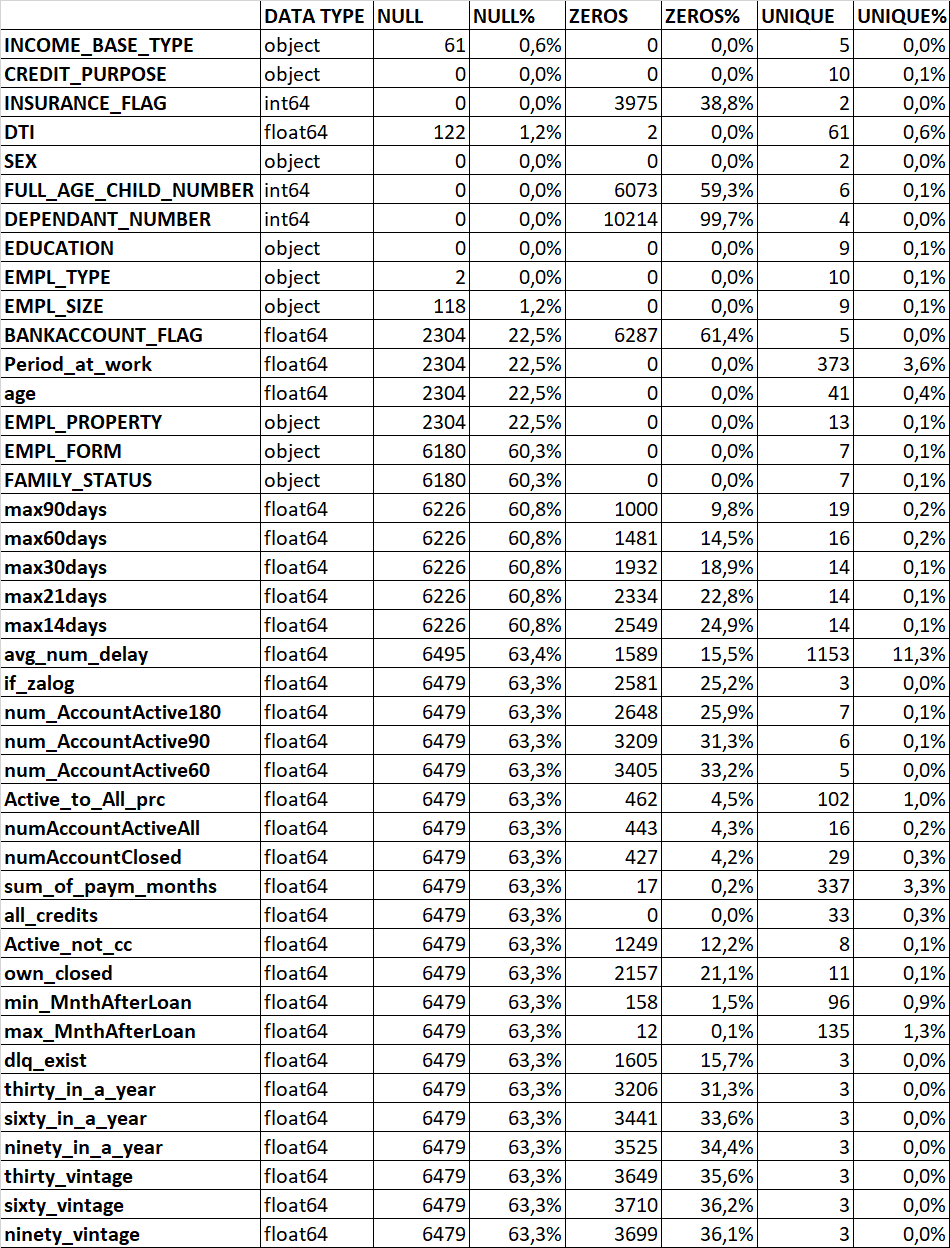

###### Посмотрим корреляционную матрицу изначального датасета

C:\Users\User\AppData\Local\Temp\ipykernel_11712\30130081.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', mask=np.zeros_like(corr, dtype=np.bool), \


Text(0.5, 1.0, 'Корреляционная матрица (ИЗНАЧАЛЬНАЯ)')

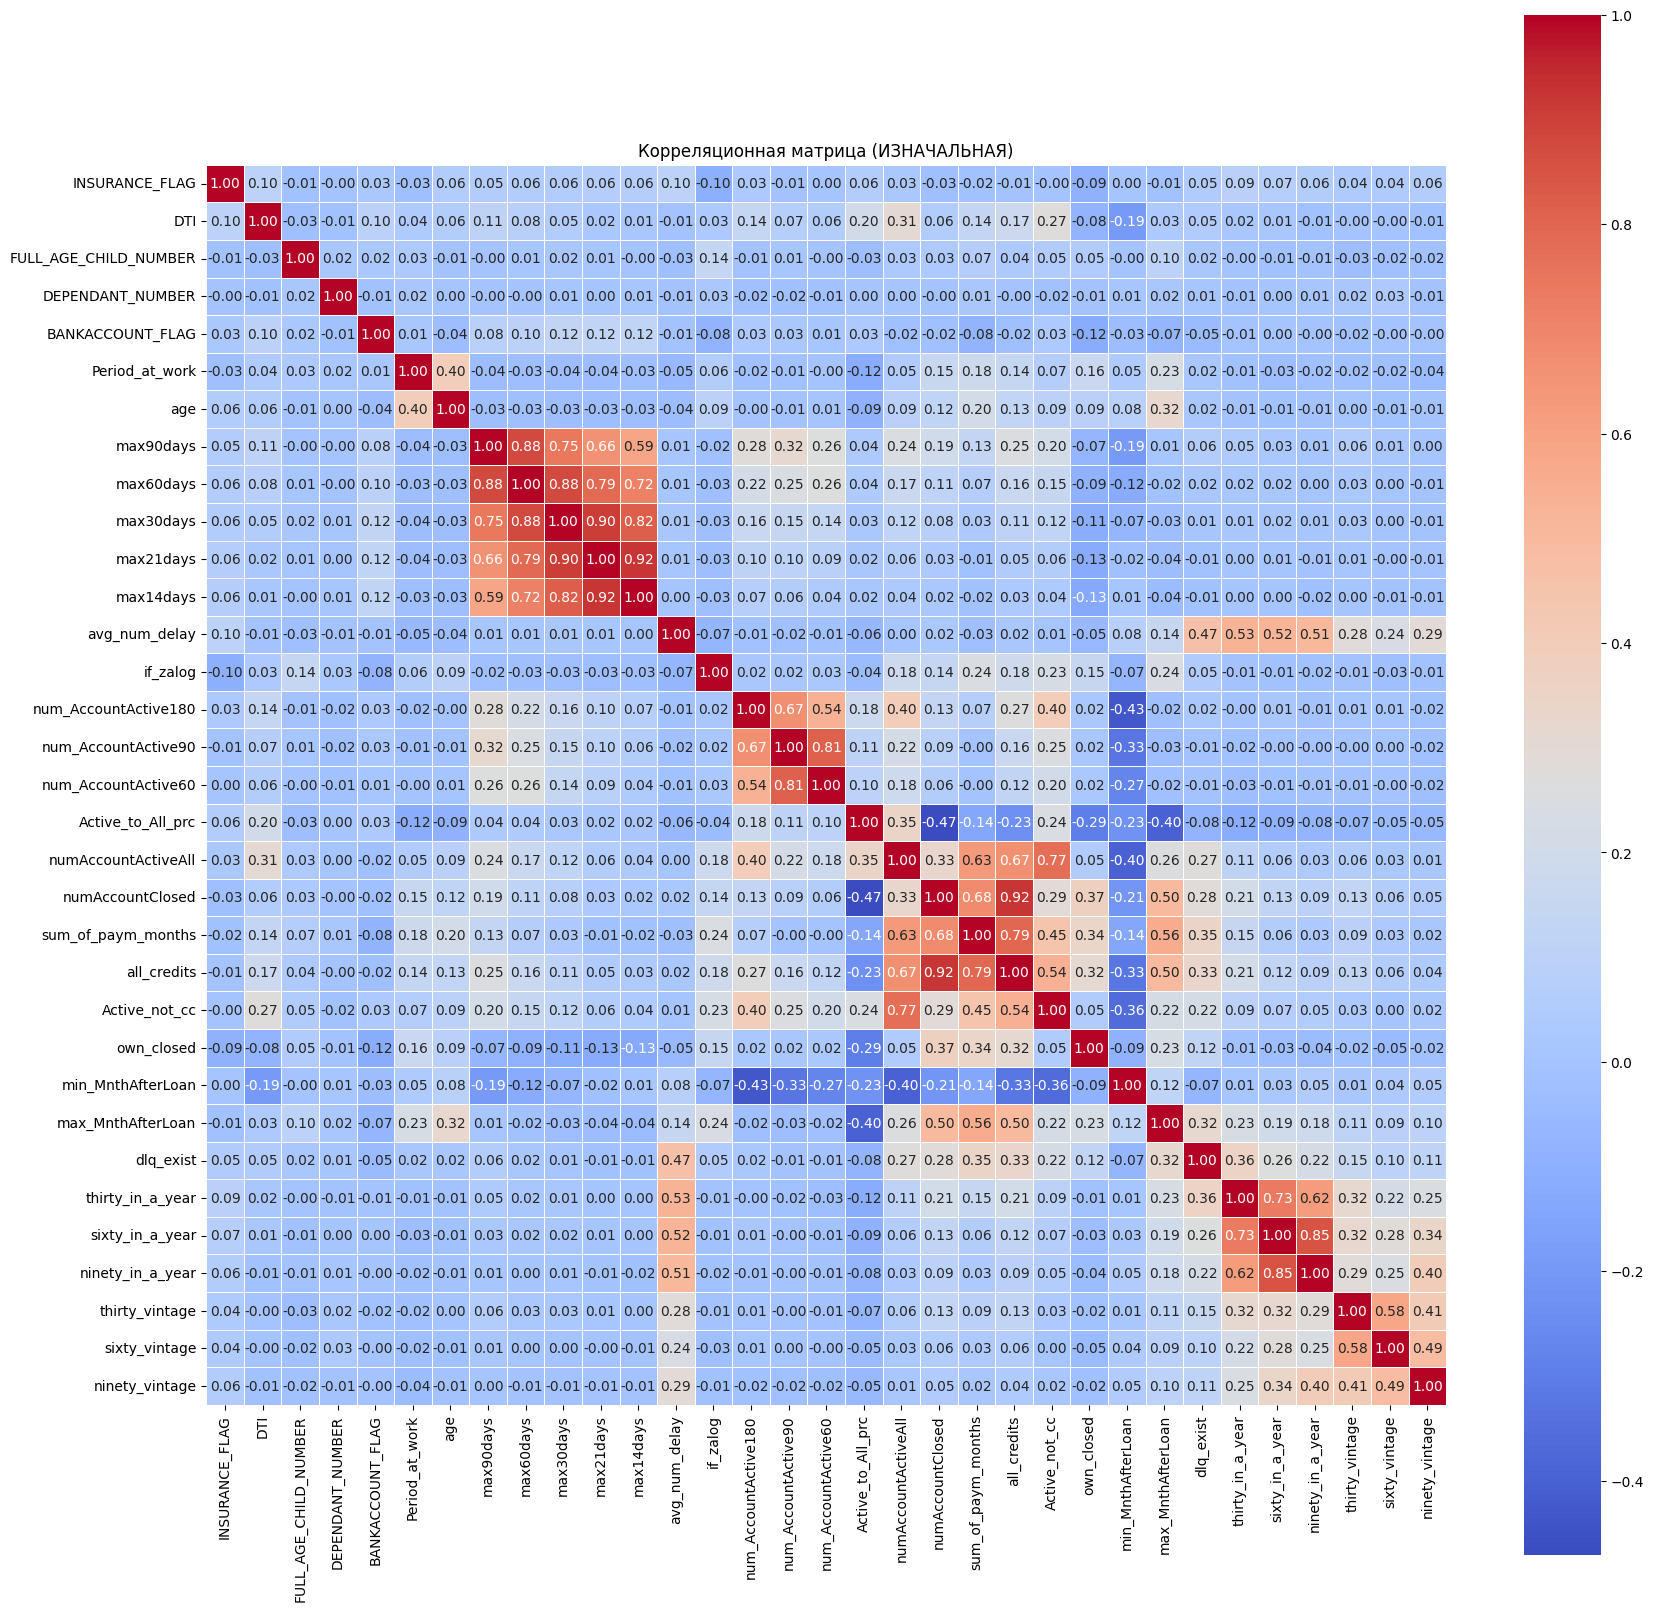

In [308]:
plt.figure(figsize=(20,20))
d_cor=df.reset_index()
d_cor=d_cor.drop(columns=['index', 'Номер варианта', 'ID'])
corr = d_cor.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.color_palette("coolwarm", as_cmap=True), square=True)
plt.title('Корреляционная матрица (ИЗНАЧАЛЬНАЯ)')
#plt.savefig('Корр матрица ДО.png', dpi=300, bbox_inches='tight')

###### Важно заметить, что здесь часть переменных является котегориальными: 
* INCOME_BASE_TYPE
* CREDIT_PURPOSE
* INSURANCE_FLAG
* SEX
* EDUCATION
* EMPL_TYPE
* EMPL_SIZE
* BANKACCOUNT_FLAG
* EMPL_PROPERTY
* EMPL_FORM
* FAMILY_STATUS
* if_zalog
* dlq_exist
* thirty_in_a_year
* sixty_in_a_year
* ninety_in_a_year
* thirty_vintage
* sixty_vintage
* ninety_vintage


###### Общая информация о числовых данных в датасете

In [309]:
df[['DTI', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'Period_at_work', 'age', 'max90days', 'max60days', 'max30days', 
   'max21days', 'max14days', 'avg_num_delay', 'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60', 
   'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed', 'sum_of_paym_months', 'all_credits', 'Active_not_cc', 
   'own_closed', 'min_MnthAfterLoan', 'max_MnthAfterLoan']].describe().transpose()

count       mean        std   min    25%        50%  \
DTI                    10120.0   0.387964   0.136878   0.0   0.28   0.400000   
FULL_AGE_CHILD_NUMBER  10242.0   0.559852   0.774799   0.0   0.00   0.000000   
DEPENDANT_NUMBER       10242.0   0.003613   0.074517   0.0   0.00   0.000000   
Period_at_work          7938.0  65.824137  67.040108   4.0  20.00  44.000000   
age                     7938.0  36.297808   8.716641  23.0  29.00  34.000000   
max90days               4016.0   1.671564   1.898272   0.0   1.00   1.000000   
max60days               4016.0   1.203187   1.545185   0.0   0.00   1.000000   
max30days               4016.0   0.894920   1.300987   0.0   0.00   1.000000   
max21days               4016.0   0.679781   1.138503   0.0   0.00   0.000000   
max14days               4016.0   0.563247   1.010275   0.0   0.00   0.000000   
avg_num_delay           3747.0   0.060748   0.111563   0.0   0.00   0.014706   
num_AccountActive180    3763.0   0.393835   0.697138   0.0   0.00   0.000000   
num_AccountActive90     3763.0   0.172203   0.442437   0.0   0.00   0.000000   
num_AccountActive60     3763.0   0.109221   0.356496   0.0   0.00   0.000000   
Active_to_All_prc       3763.0   0.430621   0.287281   0.0   0.25   0.400000   
numAccountActiveAll     3763.0   2.273186   1.739185   0.0   1.00   2.000000   
numAccountClosed        3763.0   3.565506   3.373703   0.0   1.00   3.000000   
sum_of_paym_months      3763.0  83.309328  74.097465   0.0  29.00  64.000000   
all_credits             3763.0   5.838693   4.276622   1.0   3.00   5.000000   
Active_not_cc           3763.0   1.110816   1.080590   0.0   0.00   1.000000   
own_closed              3763.0   0.713526   1.061027   0.0   0.00   0.000000   
min_MnthAfterLoan       3763.0  13.732129  14.984912  -1.0   4.00   9.000000   
max_MnthAfterLoan       3763.0  61.729471  30.371633  -1.0  35.00  68.000000   

                              75%     max  
DTI                      0.490000    0.59  
FULL_AGE_CHILD_NUMBER    1.000000    5.00  
DEPENDANT_NUMBER         0.000000    3.00  
Period_at_work          86.000000  502.00  
age                     42.000000   63.00  
max90days                2.000000   31.00  
max60days                2.000000   14.00  
max30days                1.000000   12.00  
max21days                1.000000   12.00  
max14days                1.000000   12.00  
avg_num_delay            0.072955    1.00  
num_AccountActive180     1.000000    5.00  
num_AccountActive90      0.000000    4.00  
num_AccountActive60      0.000000    4.00  
Active_to_All_prc        0.600000    1.00  
numAccountActiveAll      3.000000   15.00  
numAccountClosed         5.000000   53.00  
sum_of_paym_months     114.000000  698.00  
all_credits              8.000000   56.00  
Active_not_cc            2.000000    6.00  
own_closed               1.000000    9.00  
min_MnthAfterLoan       18.000000  106.00  
max_MnthAfterLoan       87.000000  156.00

###### Дальше помосмотрим на наличие пропусков в данных, проверим на наличие NA

In [310]:
df[df.columns].isna().sum()

Номер варианта              0
ID                          0
INCOME_BASE_TYPE           61
CREDIT_PURPOSE              0
INSURANCE_FLAG              0
DTI                       122
SEX                         0
FULL_AGE_CHILD_NUMBER       0
DEPENDANT_NUMBER            0
EDUCATION                   0
EMPL_TYPE                   2
EMPL_SIZE                 118
BANKACCOUNT_FLAG         2304
Period_at_work           2304
age                      2304
EMPL_PROPERTY            2304
EMPL_FORM                6180
FAMILY_STATUS            6180
max90days                6226
max60days                6226
max30days                6226
max21days                6226
max14days                6226
avg_num_delay            6495
if_zalog                 6479
num_AccountActive180     6479
num_AccountActive90      6479
num_AccountActive60      6479
Active_to_All_prc        6479
numAccountActiveAll      6479
numAccountClosed         6479
sum_of_paym_months       6479
all_credits              6479
Active_not

###### В последних колонках очень много пропусков, почти 2/3. Поскольку они относятся к категориальным, нам придется их удалить. Были бы числовыми, можно было бы подумать над вариантами заполнения.
###### Датасет чистим от NA. Сначала я сортирую его по тем колонкам, где больше всего NA (и NA идут первыми). Потом, зная, что пропусков у нас 6479, беру от этого датасета только конец, в котором нет NA (с 6479 позиции)

In [311]:
#сортировка
df1 = df.sort_values(by = ['if_zalog',
       'num_AccountActive180', 'num_AccountActive90', 'num_AccountActive60',
       'Active_to_All_prc', 'numAccountActiveAll', 'numAccountClosed',
       'sum_of_paym_months', 'all_credits', 'Active_not_cc', 'own_closed',
       'min_MnthAfterLoan', 'max_MnthAfterLoan', 'dlq_exist',
       'thirty_in_a_year', 'sixty_in_a_year', 'ninety_in_a_year',
       'thirty_vintage', 'sixty_vintage', 'ninety_vintage','INSURANCE_FLAG'], 
                     na_position='first')
#отбор хвоста без NA
df1 = df1[6479:].sort_values(by = 'ID')
#смотрю оставшиеся NA
df1[df1.columns].isna().sum()

Номер варианта            0
ID                        0
INCOME_BASE_TYPE          0
CREDIT_PURPOSE            0
INSURANCE_FLAG            0
DTI                       1
SEX                       0
FULL_AGE_CHILD_NUMBER     0
DEPENDANT_NUMBER          0
EDUCATION                 0
EMPL_TYPE                 0
EMPL_SIZE                 0
BANKACCOUNT_FLAG          0
Period_at_work            0
age                       0
EMPL_PROPERTY             0
EMPL_FORM                 0
FAMILY_STATUS             0
max90days                 1
max60days                 1
max30days                 1
max21days                 1
max14days                 1
avg_num_delay            16
if_zalog                  0
num_AccountActive180      0
num_AccountActive90       0
num_AccountActive60       0
Active_to_All_prc         0
numAccountActiveAll       0
numAccountClosed          0
sum_of_paym_months        0
all_credits               0
Active_not_cc             0
own_closed                0
min_MnthAfterLoan   

###### Здесь интересно, что в max90days, max60days, max30days, max21days, max14days осталось по одному пропуску. Посмотрим на них

In [312]:
df1[[ 'max90days', 'max60days', 'max30days', 'max21days', 'max14days']].sort_values(by = 'max90days', na_position='first')

max90days  max60days  max30days  max21days  max14days
5187         NaN        NaN        NaN        NaN        NaN
7127         0.0        0.0        0.0        0.0        0.0
5215         0.0        0.0        0.0        0.0        0.0
7445         0.0        0.0        0.0        0.0        0.0
1894         0.0        0.0        0.0        0.0        0.0
...          ...        ...        ...        ...        ...
3297        14.0        7.0        4.0        1.0        1.0
10022       15.0       14.0       12.0       12.0       12.0
7963        15.0        9.0        7.0        7.0        3.0
8356        20.0       13.0        7.0        7.0        7.0
1540        31.0       11.0        1.0        1.0        1.0

[3763 rows x 5 columns]

###### Все эти пропуски встречаются у одного пользователя. Поэтому мы его просто удалим, он нам погоды не сделает. Удаляем аналогичным способом, что и раньше

In [313]:
df1.sort_values(by = 'max90days', na_position='first')
df1 = df1.sort_values(by = 'max90days', na_position='first')
df1 = df1[1:]

In [314]:
df1[df1.columns].isna().sum()

Номер варианта            0
ID                        0
INCOME_BASE_TYPE          0
CREDIT_PURPOSE            0
INSURANCE_FLAG            0
DTI                       1
SEX                       0
FULL_AGE_CHILD_NUMBER     0
DEPENDANT_NUMBER          0
EDUCATION                 0
EMPL_TYPE                 0
EMPL_SIZE                 0
BANKACCOUNT_FLAG          0
Period_at_work            0
age                       0
EMPL_PROPERTY             0
EMPL_FORM                 0
FAMILY_STATUS             0
max90days                 0
max60days                 0
max30days                 0
max21days                 0
max14days                 0
avg_num_delay            16
if_zalog                  0
num_AccountActive180      0
num_AccountActive90       0
num_AccountActive60       0
Active_to_All_prc         0
numAccountActiveAll       0
numAccountClosed          0
sum_of_paym_months        0
all_credits               0
Active_not_cc             0
own_closed                0
min_MnthAfterLoan   

###### В столбцах DTI и avg_num_delay остались пропуски, которые заполняем средним по столбцу

In [315]:
df1.fillna({'avg_num_delay':df1['avg_num_delay'].mean(), 
            'DTI':df1['DTI'].mean()}, inplace=True)

###### Проверим еще раз.

In [316]:
df1[df1.columns].isna().sum()

Номер варианта           0
ID                       0
INCOME_BASE_TYPE         0
CREDIT_PURPOSE           0
INSURANCE_FLAG           0
DTI                      0
SEX                      0
FULL_AGE_CHILD_NUMBER    0
DEPENDANT_NUMBER         0
EDUCATION                0
EMPL_TYPE                0
EMPL_SIZE                0
BANKACCOUNT_FLAG         0
Period_at_work           0
age                      0
EMPL_PROPERTY            0
EMPL_FORM                0
FAMILY_STATUS            0
max90days                0
max60days                0
max30days                0
max21days                0
max14days                0
avg_num_delay            0
if_zalog                 0
num_AccountActive180     0
num_AccountActive90      0
num_AccountActive60      0
Active_to_All_prc        0
numAccountActiveAll      0
numAccountClosed         0
sum_of_paym_months       0
all_credits              0
Active_not_cc            0
own_closed               0
min_MnthAfterLoan        0
max_MnthAfterLoan        0
d

###### В ходе дополнительной проверки выяснилось, что в колонках EDUCATION и EMPL_SIZE есть пустоты в нестандартном виде

In [317]:
print(df1['EDUCATION'].unique())
print(df1['EMPL_SIZE'].unique())

['Высшее/Второе высшее/Ученая степень' 'высшее' 'среднее-специальное'
 'среднее' 'второе высшее' 'ученая степень' 'незаконченное высшее'
 '*n.a.*' 'Неполное среднее']
['< 50' '>250' '*n.a.*']


###### Так как эти переменные категориальные, строки с ними придется удалить

In [318]:
df1 = df1[df1.EDUCATION != '*n.a.*']
df1 = df1[df1.EMPL_SIZE != '*n.a.*']

###### Итак, итоговый датасет, который будем сегментировать, содержит 3750 наблюдений 
###### Посмотрим на его корреляционную матрицу

C:\Users\User\AppData\Local\Temp\ipykernel_11712\133806018.py:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', mask=np.zeros_like(corr, dtype=np.bool), \


Text(0.5, 1.0, 'Новая корреляционная матрица')

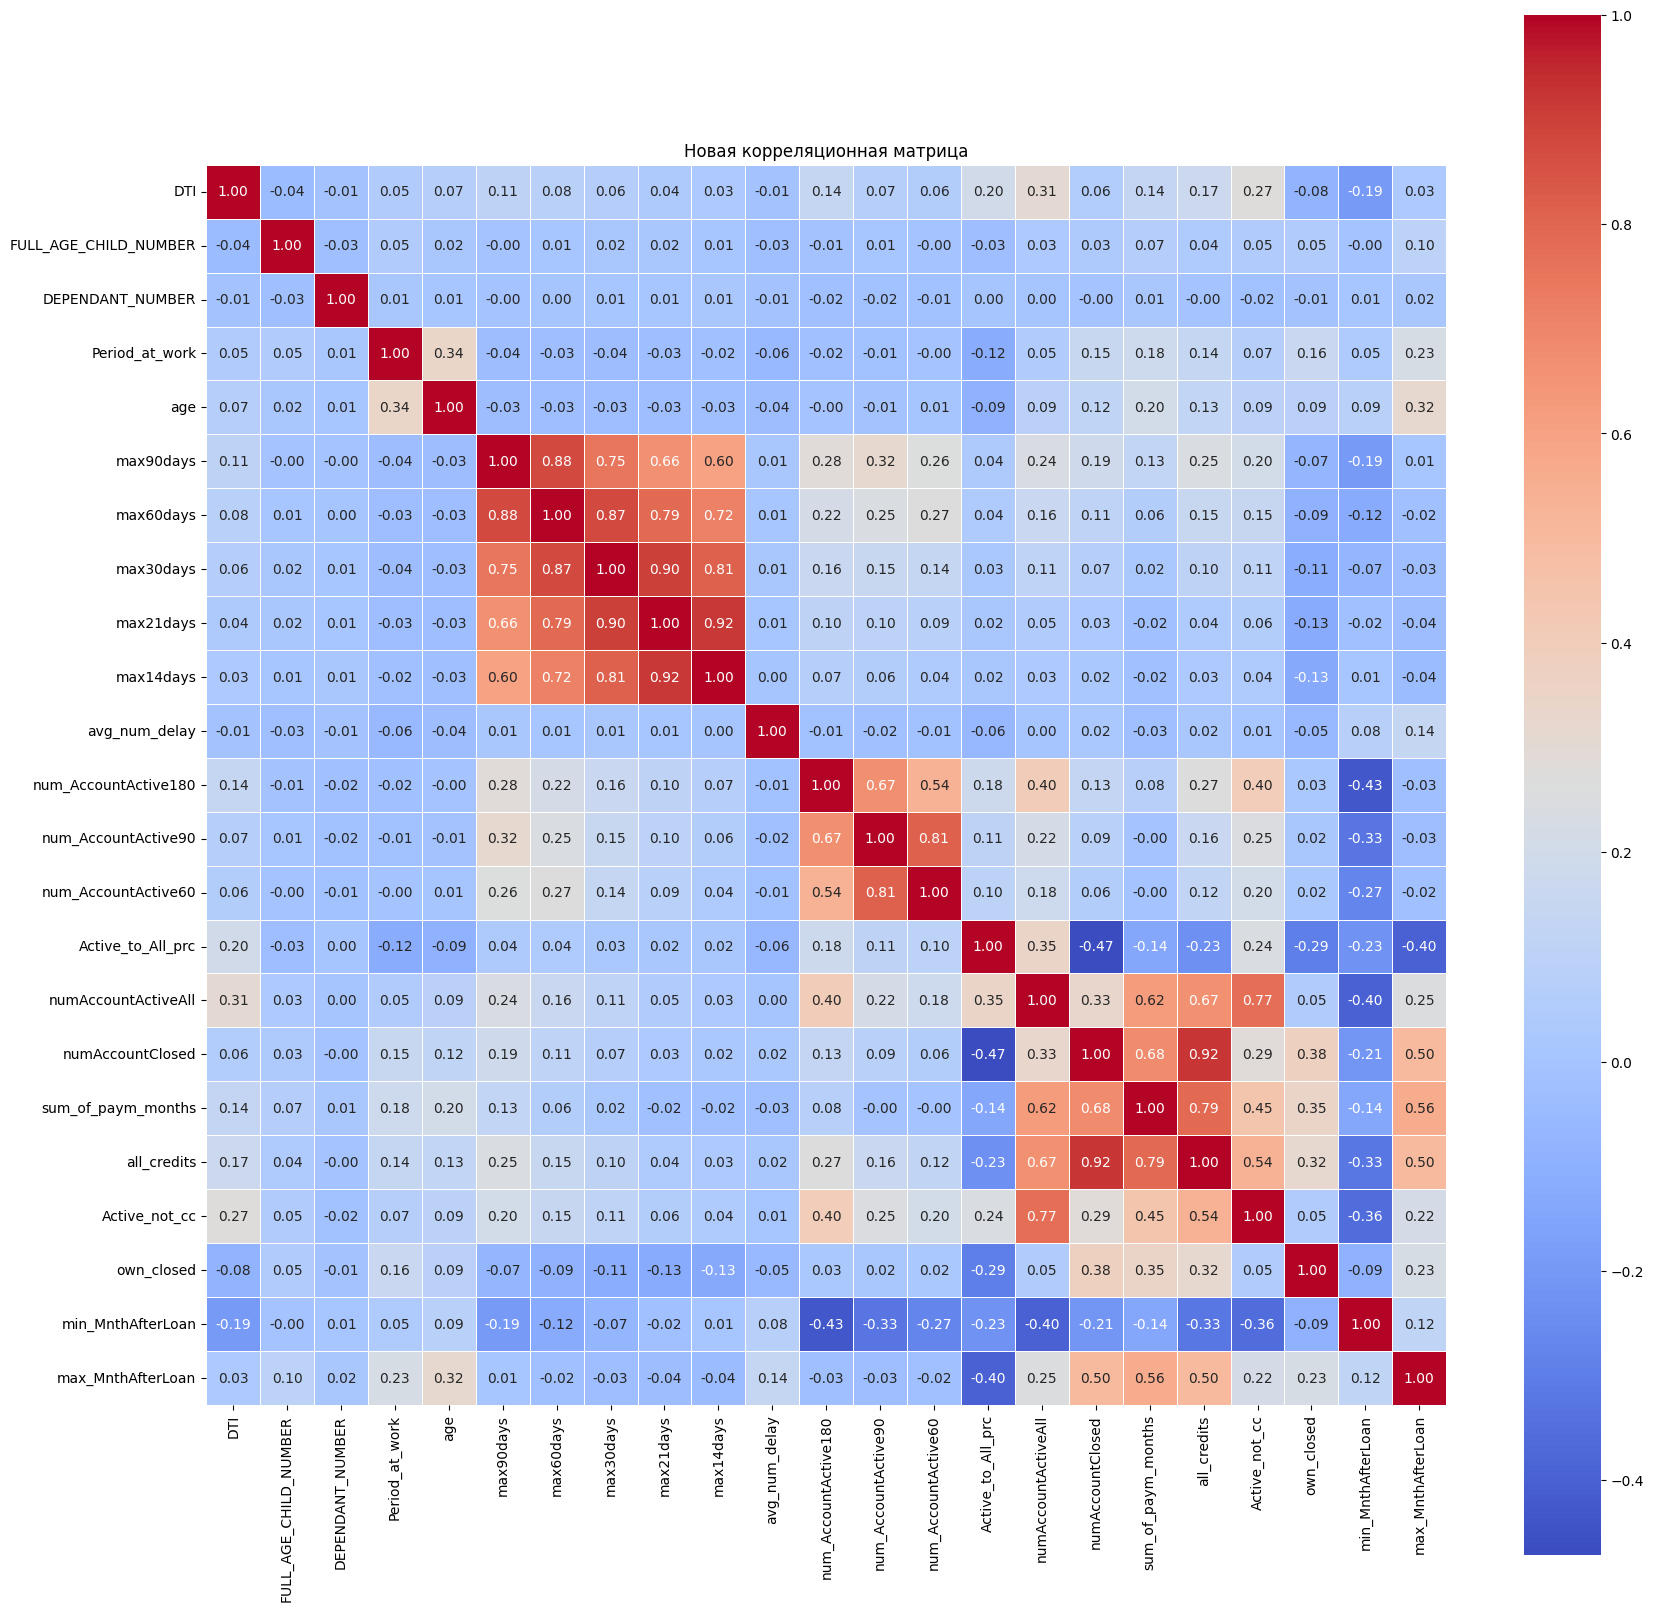

In [319]:
plt.figure(figsize=(20,20))
d_cor=df1.reset_index()
d_cor=d_cor.drop(columns=['index', 'Номер варианта', 'ID', 
'INCOME_BASE_TYPE', 
'CREDIT_PURPOSE', 
'INSURANCE_FLAG', 
'SEX', 
'EDUCATION', 
'EMPL_TYPE', 
'EMPL_SIZE', 
'BANKACCOUNT_FLAG', 
'EMPL_PROPERTY', 
'EMPL_FORM', 
'FAMILY_STATUS', 
'if_zalog', 
'dlq_exist', 
'thirty_in_a_year', 
'sixty_in_a_year', 
'ninety_in_a_year', 
'thirty_vintage', 
'sixty_vintage', 
'ninety_vintage' ])


corr = d_cor.astype('float64').corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.2f', mask=np.zeros_like(corr, dtype=np.bool), \
            cmap=sns.color_palette("coolwarm", as_cmap=True), square=True)
plt.title('Новая корреляционная матрица')

###### Наиболее явно друг с другом коррелируют признаки о запросах в кредитное бюро за посленее время (max90days, max60days, max30days, max21days, max14days). Аналогично с кол-вом активных счетов в последнее время (num_AccountActive180, num_AccountActive90, num_AccountActive60). Это можно объяснить тем, что это один и тот же показатель в разные моменты времени. Если у человека в один момент было N активных счетов или запросов в кредитное бюро, то вероятно, что и в относительно соседние даты они будут.
##### Также видна корреляция у переменной [all_credits] с [numAccountActiveAll, numAccountClosed, sum_of_paym_months], а также у [sum_of_paym_months] c [numAccountActiveAll, numAccountClosed]. Это тоже объяснимо. размер платежей у клиента тем больше, чем больше у него кредитов.



###### Посмотрим на гистограммы распрделения для категориальных бинарных переменных. Портрет типичного клиента на основе графиков будет дальше 
* INSURANCE_FLAG
* SEX
* if_zalog
* dlq_exist
* thirty_in_a_year
* sixty_in_a_year
* ninety_in_a_year
* thirty_vintage
* sixty_vintage
* ninety_vintage

<AxesSubplot: xlabel='ninety_vintage', ylabel='count'>

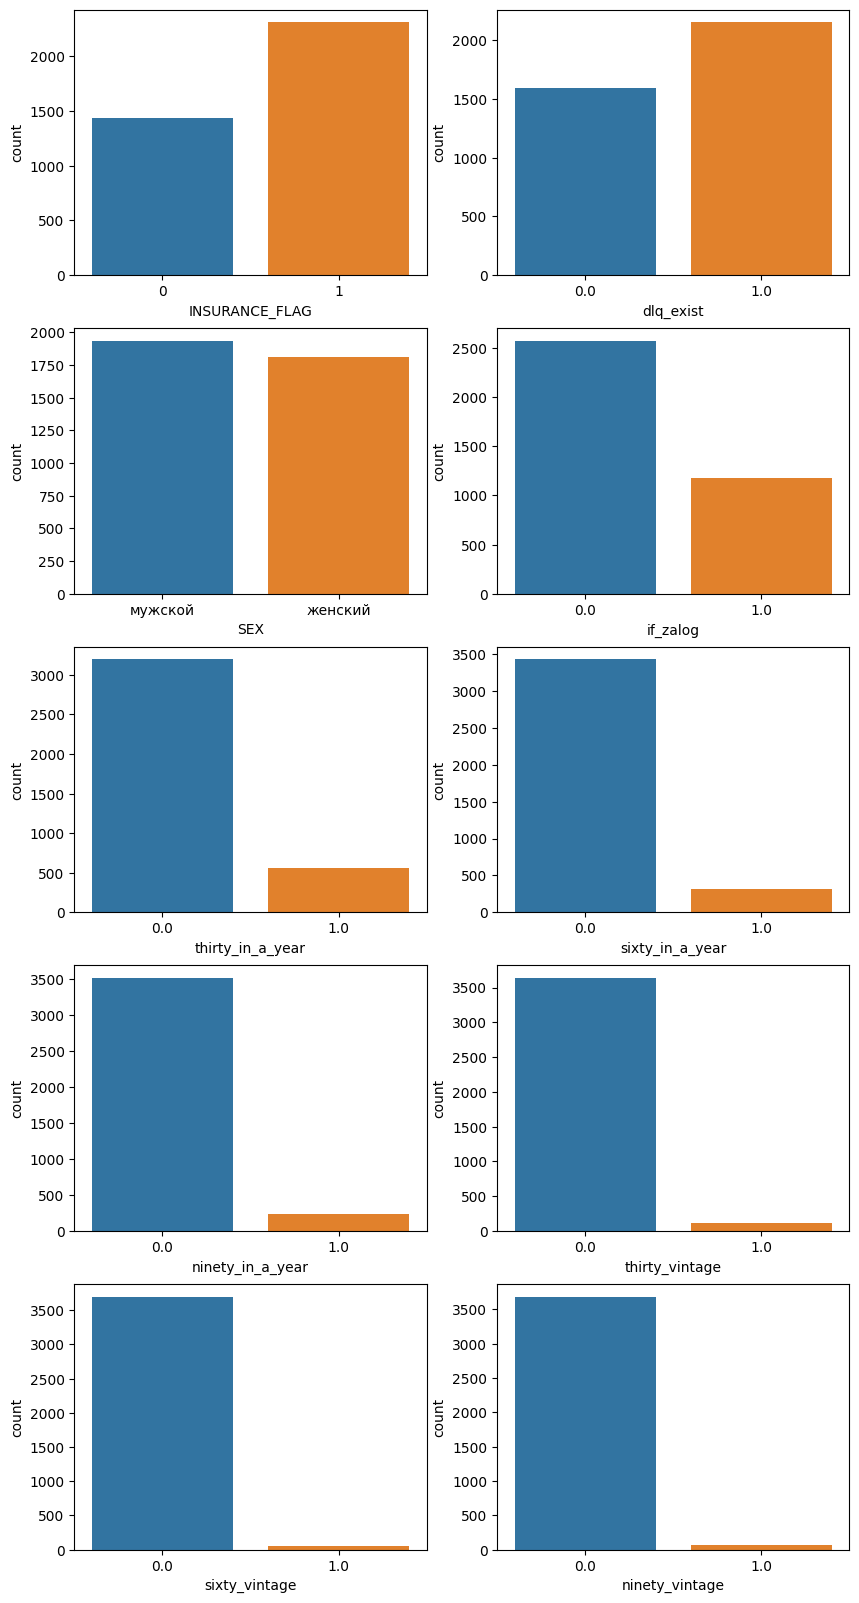

In [320]:
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
sns.countplot(x='INSURANCE_FLAG', data=df1, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=df1, ax=axs[0,1])
sns.countplot(x='SEX', data=df1, ax=axs[1,0])
sns.countplot(x='if_zalog',data=df1, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=df1, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=df1, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=df1, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=df1, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=df1, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=df1, ax=axs[4,1])


###### Посмотрим на гистограммы распрделения для категориальных небинарных переменных 
* BANKACCOUNT_FLAG
* INCOME_BASE_TYPE
* CREDIT_PURPOSE
* EDUCATION
* EMPL_TYPE
* EMPL_SIZE
* EMPL_PROPERTY
* EMPL_FORM
* FAMILY_STATUS

<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

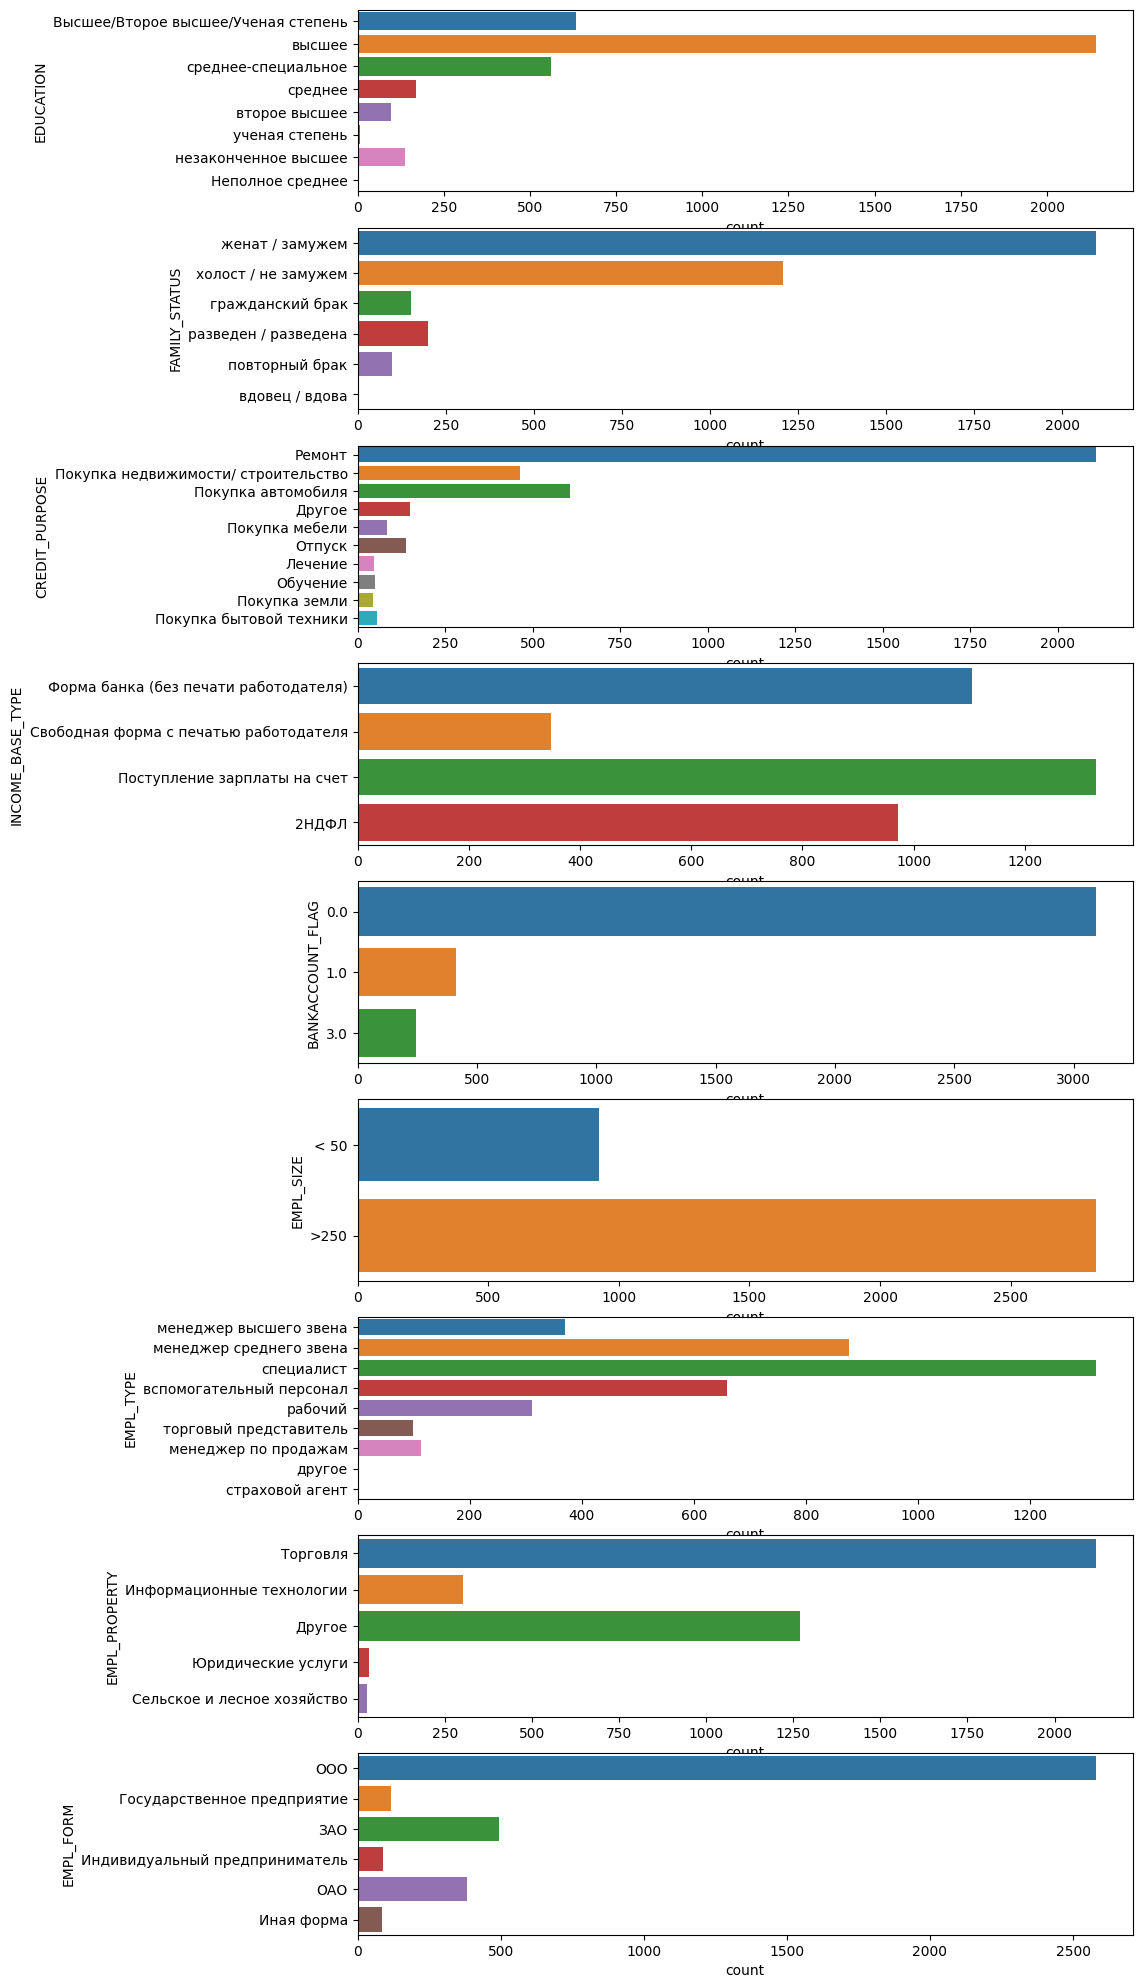

In [321]:
fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=df1, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=df1, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=df1, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=df1, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=df1, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=df1, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=df1, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=df1, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=df1, ax=axs[8])


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 [Text(0, 0, '23.0'),
  Text(1, 0, '24.0'),
  Text(2, 0, '25.0'),
  Text(3, 0, '26.0'),
  Text(4, 0, '27.0'),
  Text(5, 0, '28.0'),
  Text(6, 0, '29.0'),
  Text(7, 0, '30.0'),
  Text(8, 0, '31.0'),
  Text(9, 0, '32.0'),
  Text(10, 0, '33.0'),
  Text(11, 0, '34.0'),
  Text(12, 0, '35.0'),
  Text(13, 0, '36.0'),
  Text(14, 0, '37.0'),
  Text(15, 0, '38.0'),
  Text(16, 0, '39.0'),
  Text(17, 0, '40.0'),
  Text(18, 0, '41.0'),
  Text(19, 0, '42.0'),
  Text(20, 0, '43.0'),
  Text(21, 0, '44.0'),
  Text(22, 0, '45.0'),
  Text(23, 0, '46.0'),
  Text(24, 0, '47.0'),
  Text(25, 0, '48.0'),
  Text(26, 0, '49.0'),
  Text(27, 0, '50.0'),
  Text(28, 0, '51.0'),
  Text(29, 0, '52.0'),
  Text(30, 0, '53.0'),
  Text(31, 0, '54.0'),
  Text(32, 0, '55.0'),
  Text(33, 0, '56.0'),
  Text(34, 0, '57.0'),
  Text(35, 0, '58.0'),
  Te

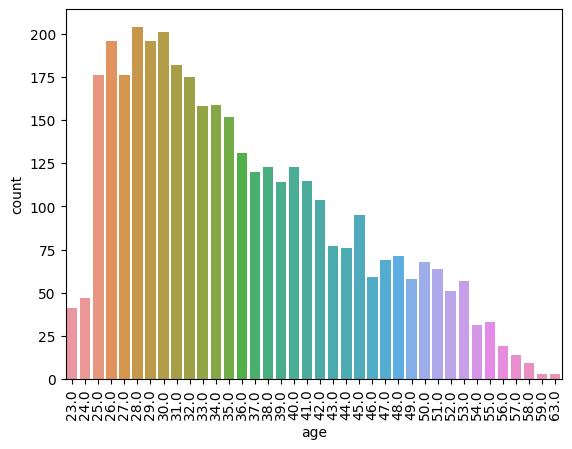

In [322]:
sns.countplot(x='age', data=df1)
plt.xticks(rotation = 90)

<AxesSubplot: xlabel='age'>

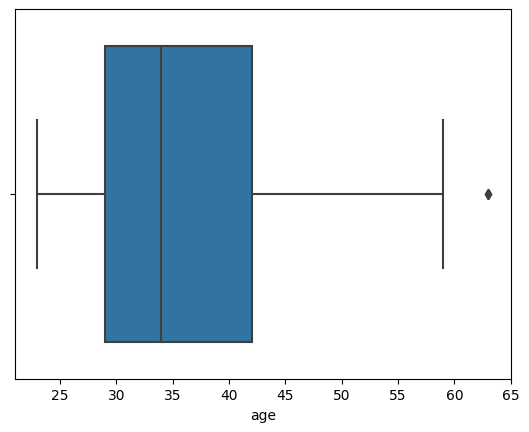

In [323]:
sns.boxplot(x=df1["age"])

###### Наши клиент с точки зрения возрастного распределния молодые. Основной костяк криентов - люди в возрасте примерно 28-42 лет. При этом видно, что в 23-24 года клиентов относительно немного, потом в 25 лет резкий рост, продолжющийся до 28 лет, а затем постепенное затухание с возрастом 
###### Типичный клиент:
* Мужчина
* 28 лет
* Женат
* С высшим образованием
* Работает специалистом в торговле (ООО)
* Зарабатывает больше 250 ед.
* Берет беззалоговый кредит на ремонт, но со страховкой
* Имеет просрочки по платежам, но не больше месяца


In [324]:
df1 = df1.drop(columns = 'Номер варианта')
df1 = df1.reset_index(drop=True)
df1

ID                        INCOME_BASE_TYPE  \
0     1142551   Форма банка (без печати работодателя)   
1     1104311  Свободная форма с печатью работодателя   
2     1148911  Свободная форма с печатью работодателя   
3     1037891            Поступление зарплаты на счет   
4     1148871   Форма банка (без печати работодателя)   
...       ...                                     ...   
3745  1065951                                   2НДФЛ   
3746  1200451                                   2НДФЛ   
3747  1159271                                   2НДФЛ   
3748  1167131  Свободная форма с печатью работодателя   
3749  1030811                                   2НДФЛ   

                           CREDIT_PURPOSE  INSURANCE_FLAG   DTI      SEX  \
0                                  Ремонт               1  0.07  мужской   
1     Покупка недвижимости/ строительство               0  0.45  женский   
2                                  Ремонт               0  0.38  женский   
3                                  Ремонт               1  0.43  женский   
4                      Покупка автомобиля               0  0.20  мужской   
...                                   ...             ...   ...      ...   
3745                               Ремонт               1  0.59  женский   
3746                               Ремонт               1  0.46  женский   
3747                               Ремонт               1  0.34  женский   
3748                               Ремонт               1  0.35  женский   
3749  Покупка недвижимости/ строительство               1  0.27  женский   

      FULL_AGE_CHILD_NUMBER  DEPENDANT_NUMBER  \
0                         0                 0   
1                         0                 0   
2                         0                 0   
3                         0                 0   
4                         0                 0   
...                     ...               ...   
3745                      0                 0   
3746                      0                 0   
3747                      2                 0   
3748                      0                 0   
3749                      0                 0   

                                EDUCATION                 EMPL_TYPE  ...  \
0     Высшее/Второе высшее/Ученая степень    менеджер высшего звена  ...   
1     Высшее/Второе высшее/Ученая степень   менеджер среднего звена  ...   
2     Высшее/Второе высшее/Ученая степень                специалист  ...   
3     Высшее/Второе высшее/Ученая степень    менеджер высшего звена  ...   
4                                  высшее  вспомогательный персонал  ...   
...                                   ...                       ...  ...   
3745                  среднее-специальное  вспомогательный персонал  ...   
3746                               высшее                специалист  ...   
3747                               высшее                специалист  ...   
3748                               высшее  вспомогательный персонал  ...   
3749                               высшее                специалист  ...   

     own_closed  min_MnthAfterLoan  max_MnthAfterLoan  dlq_exist  \
0           3.0               14.0              100.0        0.0   
1           3.0                5.0              126.0        1.0   
2           0.0               12.0               12.0        0.0   
3           0.0               25.0              115.0        1.0   
4           2.0               40.0               75.0        1.0   
...         ...                ...                ...        ...   
3745        0.0                5.0               86.0        1.0   
3746        0.0               11.0               89.0        1.0   
3747        0.0                1.0               36.0        1.0   
3748        0.0                2.0                4.0        1.0   
3749        0.0                1.0                1.0        0.0   

     thirty_in_a_year sixty_in_a_year ninety_in_a_year  thirty_vintage  \
0                 0.

### Итоговый датасет - df1. ID не пригодится при кластеризации, но оставим, чтобы индентифицировать клиента

# Часть 2. Профили клиентов

###### Сбросим ID, потому что он будет мешать при кластеризации 

In [325]:
dataset = df1.drop(columns = 'ID')

## KMeans
#### У нас много данных, поэтому должно неплохо получиться обучить модеть + карсивая и наглядная визуализация. Сложности есть с определением количества кластеров. Методом локтя и экспертным попробую найти золотую середину.

###### Закодируем категориальные переменные. Буду делать это через OneHotEncoder. Он мне кажется самым удачным. В некоторых столбцах у нас категориальная переменная принимает до 10 значений. Если бы я кодировал просто цифрами, то получилось бы, что, допустим, человек с ученой степень получает больше человка с двумя высшими образованиями. Если использовать экспертный подход, то, на мой взгляд, это не так. Поэтому беру OneHot
###### Также с помощью StandardScaler отмасштабирую величины. Если одни величины очень большие, а другие - маленькие, то разницы в масштабе может плохо сказаться на качесте

In [326]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler
one_enc = OneHotEncoder()
data = one_enc.fit_transform(dataset)
scaler = StandardScaler()
data = scaler.fit_transform(data)

##### Задействую метод главных компонент, чтобы сократить размерность

In [327]:
pca = PCA(n_components=2)
res = pca.fit_transform(data)

res

array([[ 0.10908495, -3.49332291],
       [ 2.27506464, -3.00184135],
       [-3.32612814,  0.66071245],
       ...,
       [ 8.40851167,  9.28236988],
       [ 6.79956199, 13.29153875],
       [ 3.89115983,  9.90930003]])

###### Далее для кластеризации методом KMeans мне нужно подобрать число кластеров. Воспользуюсь методом локтя

Text(0.5, 1.0, 'Метод локтя')

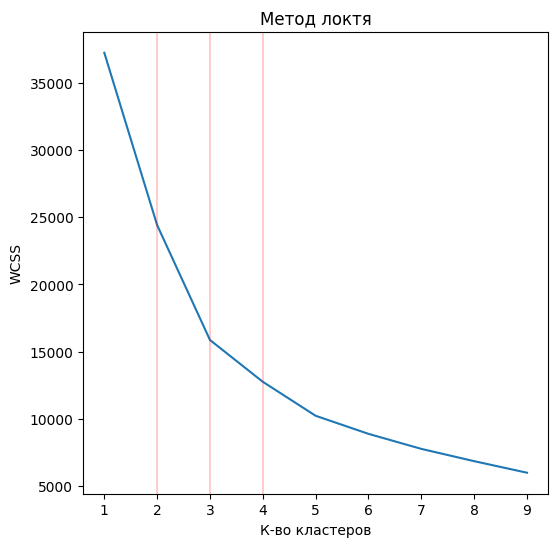

In [328]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 10):
    kms = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init = 10, random_state=3)
    kms.fit(res)
    wcss.append(kms.inertia_)
plt.figure(figsize = (6,6))
plt.plot(range(1, 10), wcss)
plt.axvline(x = 2, color = 'r', alpha = 0.2)
plt.axvline(x = 3, color = 'r', alpha = 0.2)
plt.axvline(x = 4, color = 'r', alpha = 0.2)
plt.xlabel('К-во кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя')

###### Основные переломы в 2,3 и 4. 2 и 3 - слишком мало для кластеризации. Поэтому остановлюсь на 4

###### Обучаю модель с подобранным гиперпараметром, строю кластеры на графике

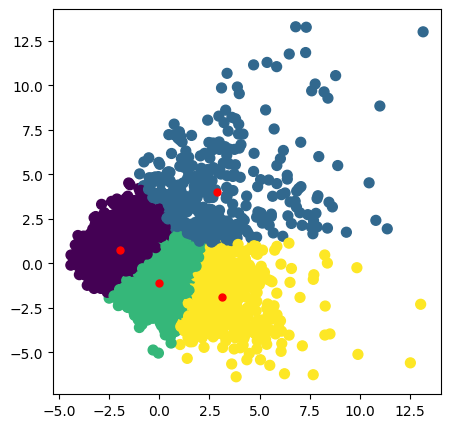

In [329]:
kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 300, n_init = 10, random_state=3)
kmeans.fit_predict(res)

plt.figure(figsize=(5,5))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', s=25)


##### Присоединяю kmeans.labels_ к датасету новым столбцом, а потом разбиваю датасет на 4 новых по кластерам

In [330]:
dfc = df1
dfc['cluster'] = kmeans.labels_.tolist()
cl1 = dfc.loc[dfc['cluster'] == 0]
cl2 = dfc.loc[dfc['cluster'] == 1]
cl3 = dfc.loc[dfc['cluster'] == 2]
cl4 = dfc.loc[dfc['cluster'] == 3]


##### Смотрю в общей таблице на значения средних для каждого кластера. Здесь затесались некоторые категориальные, на них не обращаю внимания 

In [331]:
cl_mean = pd.DataFrame()
cl_mean['1'] = cl1.mean()
cl_mean['2'] = cl2.mean()
cl_mean['3'] = cl3.mean()
cl_mean['4'] = cl4.mean()

cl_mean

C:\Users\User\AppData\Local\Temp\ipykernel_11712\1526587981.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cl_mean['1'] = cl1.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\1526587981.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cl_mean['2'] = cl2.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\1526587981.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  cl_mean['3'] = cl3.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\1526587981.py:5: FutureWarn

1             2             3             4
ID                     1.093841e+06  1.109865e+06  1.098013e+06  1.105840e+06
INSURANCE_FLAG         6.190476e-01  6.920981e-01  5.876289e-01  6.302083e-01
DTI                    3.708558e-01  4.314435e-01  3.825847e-01  4.289583e-01
FULL_AGE_CHILD_NUMBER  4.527260e-01  5.231608e-01  5.979381e-01  6.875000e-01
DEPENDANT_NUMBER       3.450656e-03  0.000000e+00  2.209131e-03  3.472222e-03
BANKACCOUNT_FLAG       3.616287e-01  6.566757e-01  2.054492e-01  1.840278e-01
Period_at_work         4.435887e+01  4.845777e+01  6.266716e+01  7.405208e+01
age                    3.380055e+01  3.468665e+01  3.730928e+01  3.914236e+01
max90days              1.102830e+00  5.389646e+00  1.094256e+00  2.177083e+00
max60days              7.915804e-01  4.452316e+00  6.723122e-01  1.333333e+00
max30days              5.942029e-01  3.580381e+00  4.300442e-01  8.489583e-01
max21days              4.541063e-01  2.918256e+00  2.849779e-01  4.878472e-01
max14days              3.795721e-01  2.405995e+00  2.150221e-01  3.802083e-01
avg_num_delay          3.063551e-02  6.373179e-02  8.016014e-02  8.975300e-02
if_zalog               1.463078e-01  2.425068e-01  4.293078e-01  5.069444e-01
num_AccountActive180   2.146308e-01  9.918256e-01  2.827688e-01  7.274306e-01
num_AccountActive90    8.419600e-02  5.912807e-01  9.941090e-02  2.986111e-01
num_AccountActive60    4.485852e-02  4.386921e-01  5.301915e-02  1.961806e-01
Active_to_All_prc      4.854619e-01  4.976695e-01  3.750113e-01  3.792791e-01
numAccountActiveAll    1.265010e+00  2.915531e+00  2.281296e+00  4.357639e+00
numAccountClosed       1.564527e+00  3.651226e+00  3.932253e+00  7.690972e+00
sum_of_paym_months     3.417184e+01  7.411717e+01  9.376657e+01  1.876580e+02
all_credits            2.829538e+00  6.566757e+00  6.213549e+00  1.204861e+01
Active_not_cc          5.307108e-01  1.547684e+00  1.123711e+00  2.255208e+00
own_closed             3.526570e-01  3.814714e-01  9.720177e-01  1.227431e+00
min_MnthAfterLoan      1.815597e+01  7.275204e+00  1.357511e+01  7.114583e+00
max_MnthAfterLoan      4.106142e+01  5.541689e+01  7.396318e+01  8.890799e+01
dlq_exist              3.064182e-01  5.776567e-01  7.194404e-01  9.027778e-01
thirty_in_a_year       2.208420e-02  1.253406e-01  1.796760e-01  4.062500e-01
sixty_in_a_year        3.450656e-03  7.084469e-02  1.067747e-01  2.534722e-01
ninety_in_a_year       6.901311e-04  3.814714e-02  7.952872e-02  1.996528e-01
thirty_vintage         2.070393e-03  3.269755e-02  2.724595e-02  1.076389e-01
sixty_vintage          6.901311e-04  1.362398e-02  1.178203e-02  5.381944e-02
ninety_vintage         0.000000e+00  1.089918e-02  1.767305e-02  6.250000e-02
cluster                0.000000e+00  1.000000e+00  2.000000e+00  3.000000e+00

#### Строю графики для каждого кластера, чтобы найти в нем характерные черты
###### 1 кластер

<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

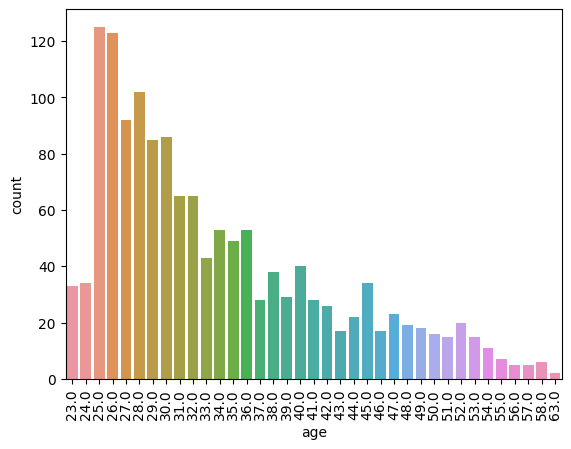

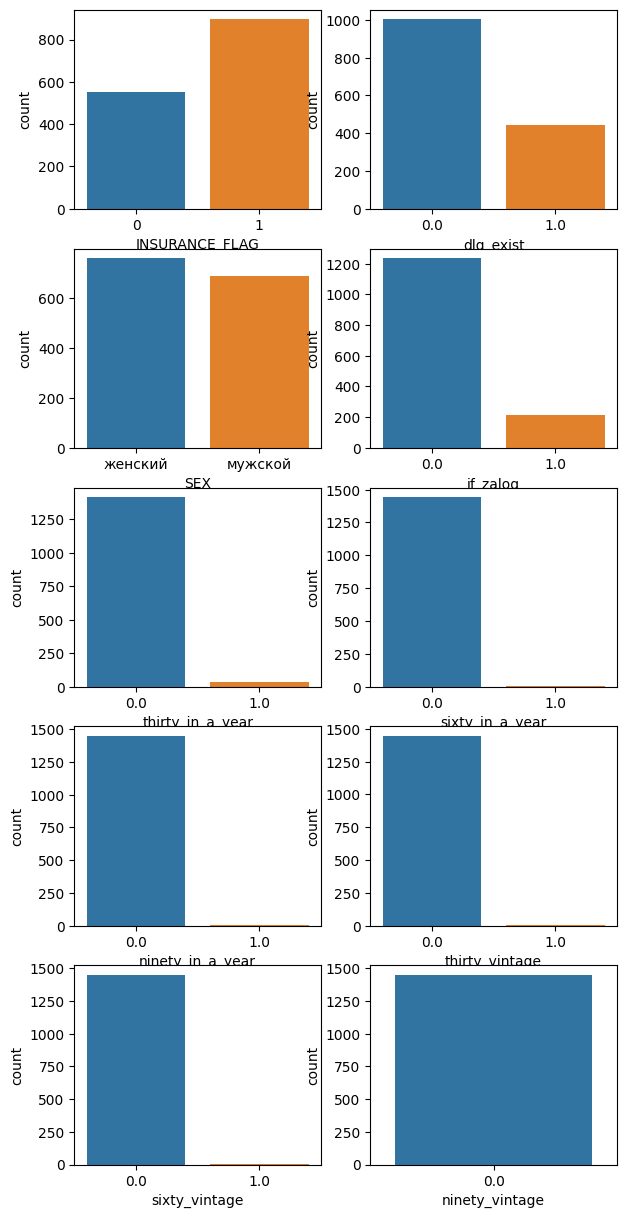

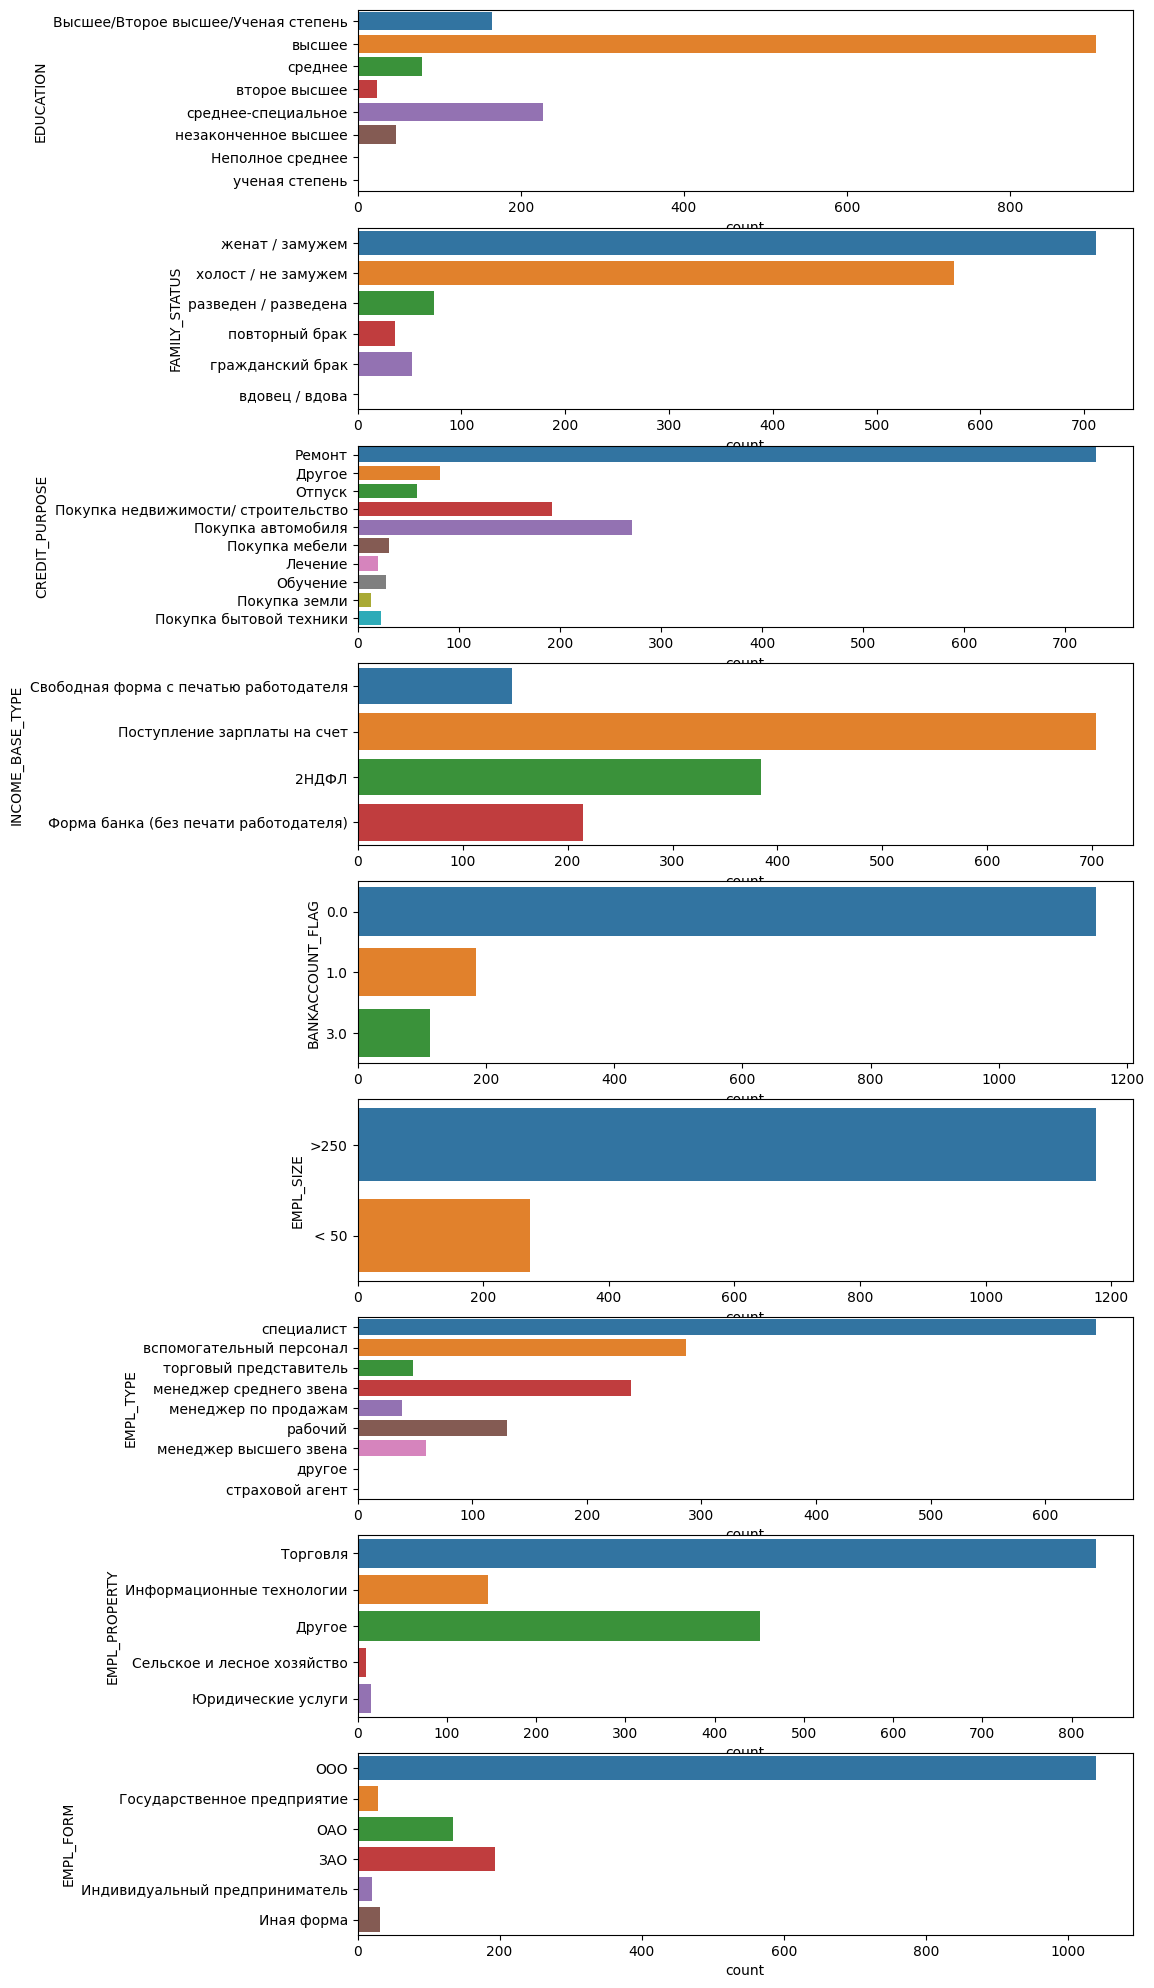

In [332]:
sns.countplot(x='age', data=cl1)
plt.xticks(rotation = 90)

fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=cl1, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=cl1, ax=axs[0,1])
sns.countplot(x='SEX', data=cl1, ax=axs[1,0])
sns.countplot(x='if_zalog',data=cl1, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=cl1, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=cl1, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=cl1, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=cl1, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=cl1, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=cl1, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=cl1, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=cl1, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=cl1, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=cl1, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=cl1, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=cl1, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=cl1, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=cl1, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=cl1, ax=axs[8])


<AxesSubplot: xlabel='age'>

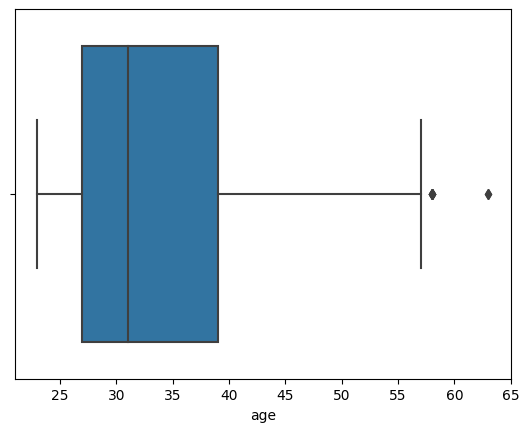

In [333]:
sns.boxplot(x=cl1["age"])

##### 2 кластер

<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

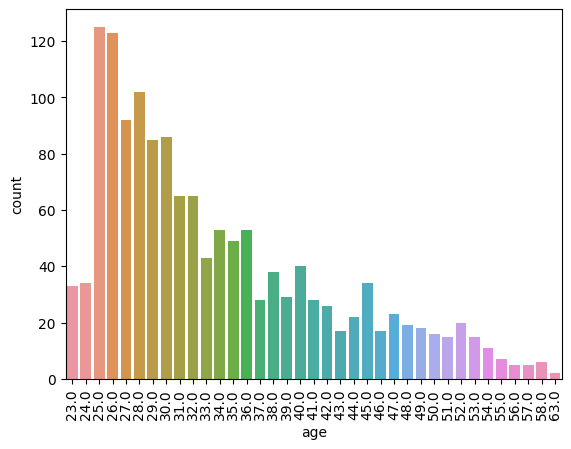

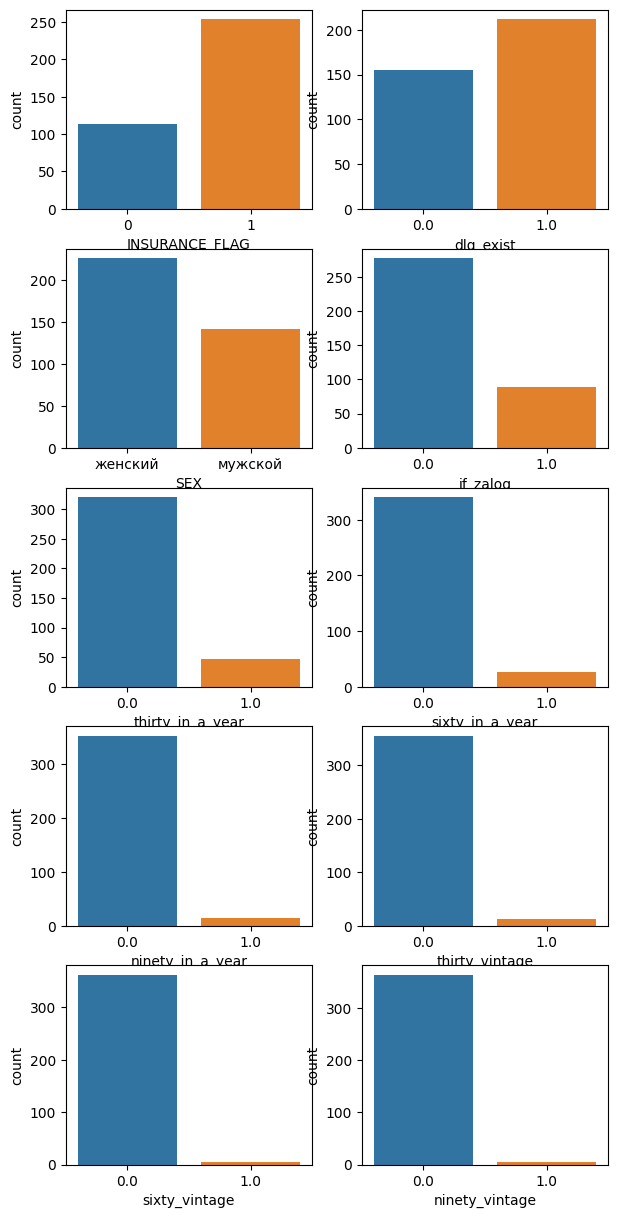

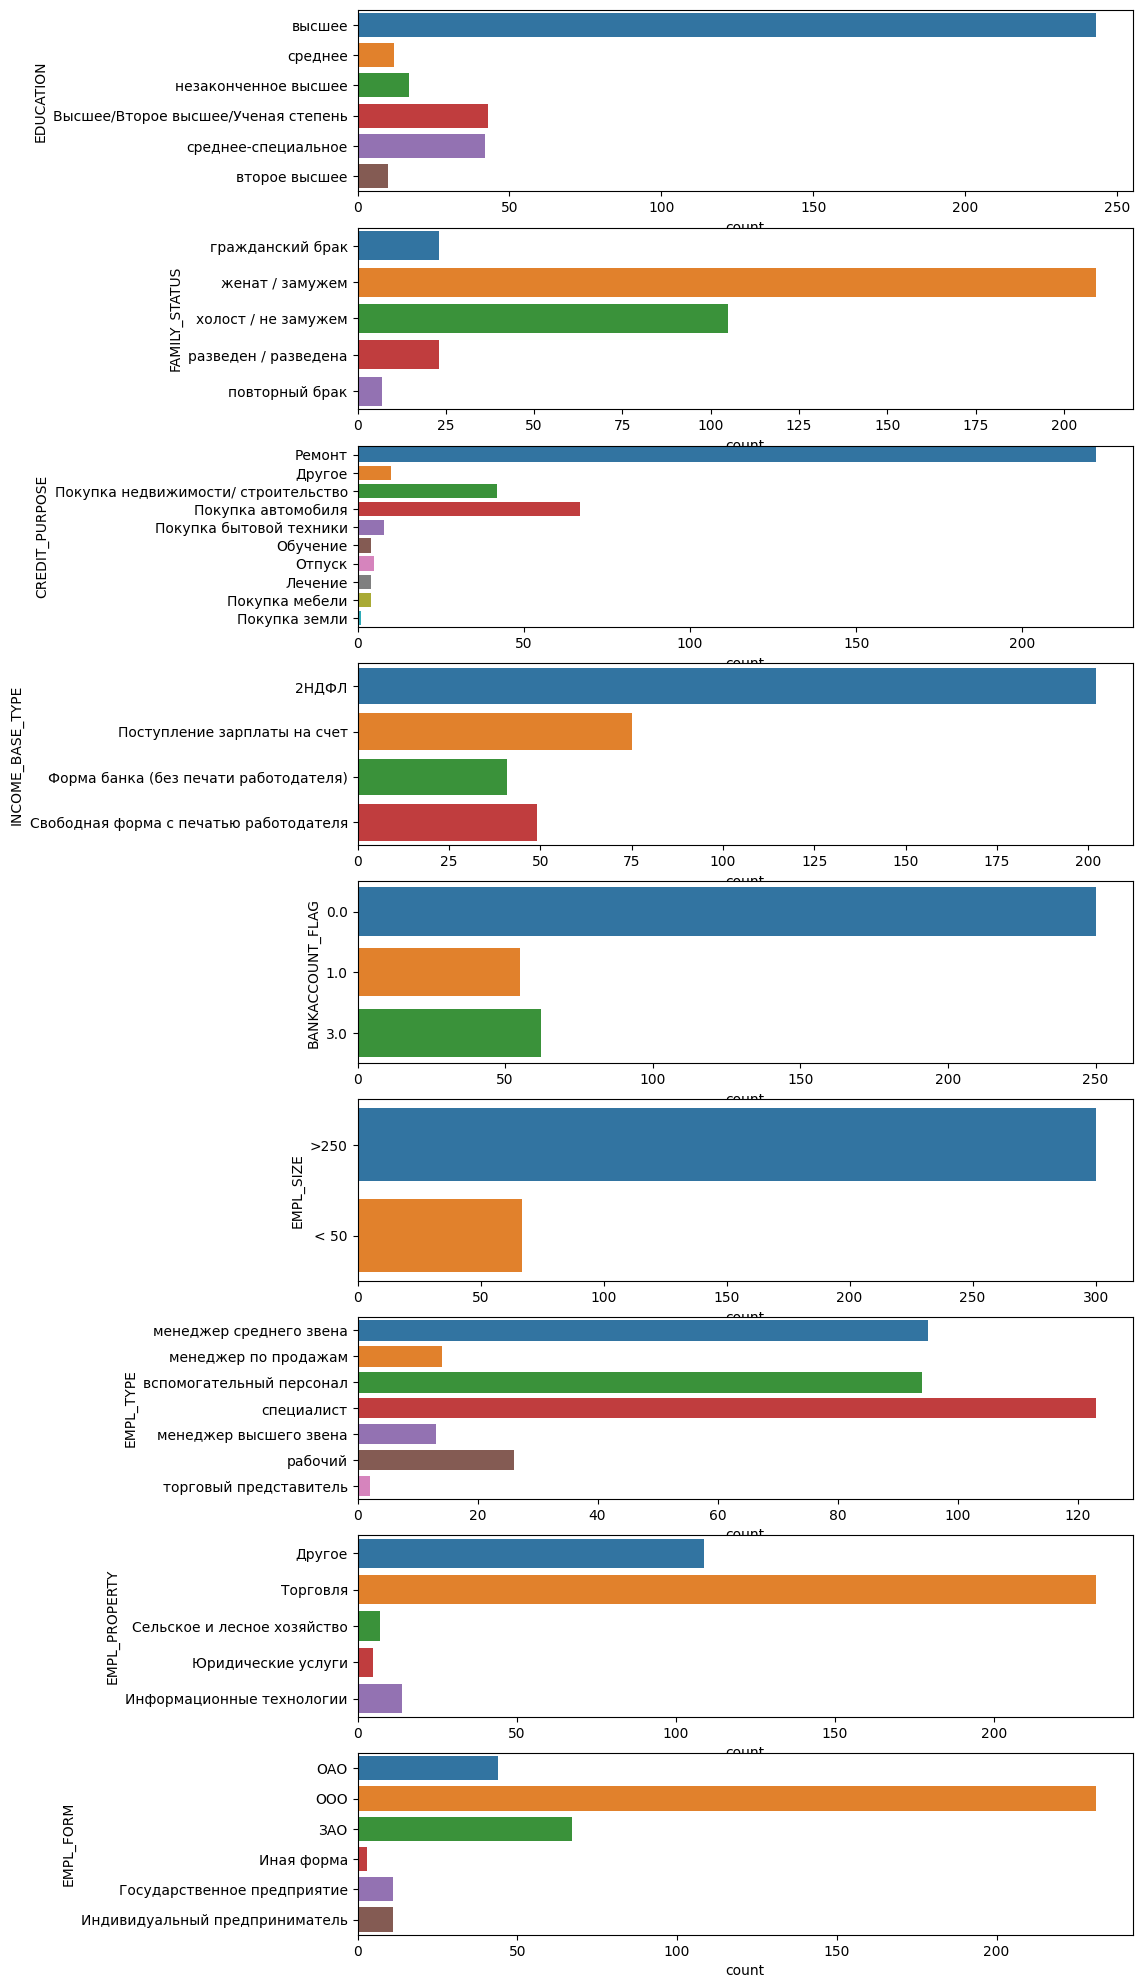

In [334]:
sns.countplot(x='age', data=cl1)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=cl2, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=cl2, ax=axs[0,1])
sns.countplot(x='SEX', data=cl2, ax=axs[1,0])
sns.countplot(x='if_zalog',data=cl2, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=cl2, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=cl2, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=cl2, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=cl2, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=cl2, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=cl2, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=cl2, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=cl2, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=cl2, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=cl2, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=cl2, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=cl2, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=cl2, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=cl2, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=cl2, ax=axs[8])

<AxesSubplot: xlabel='age'>

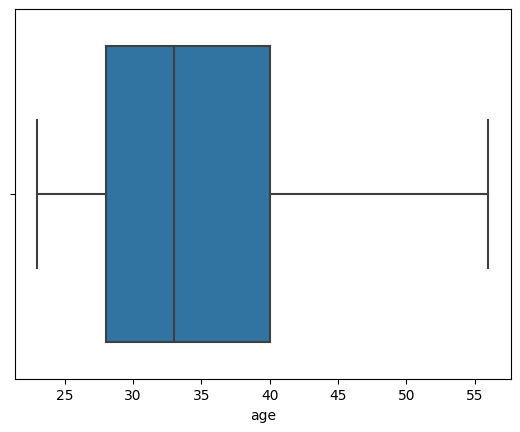

In [335]:
sns.boxplot(x=cl2["age"])

###### 3 кластер

<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

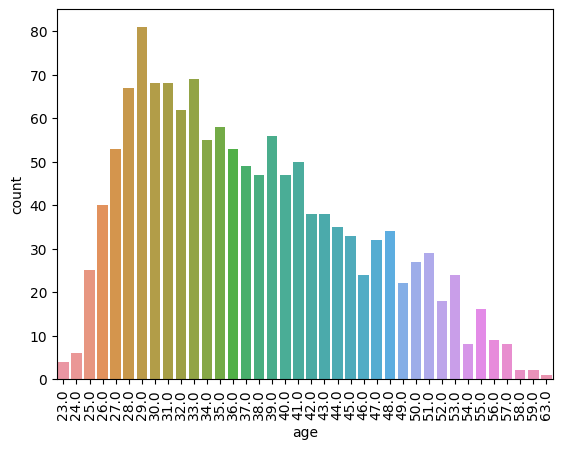

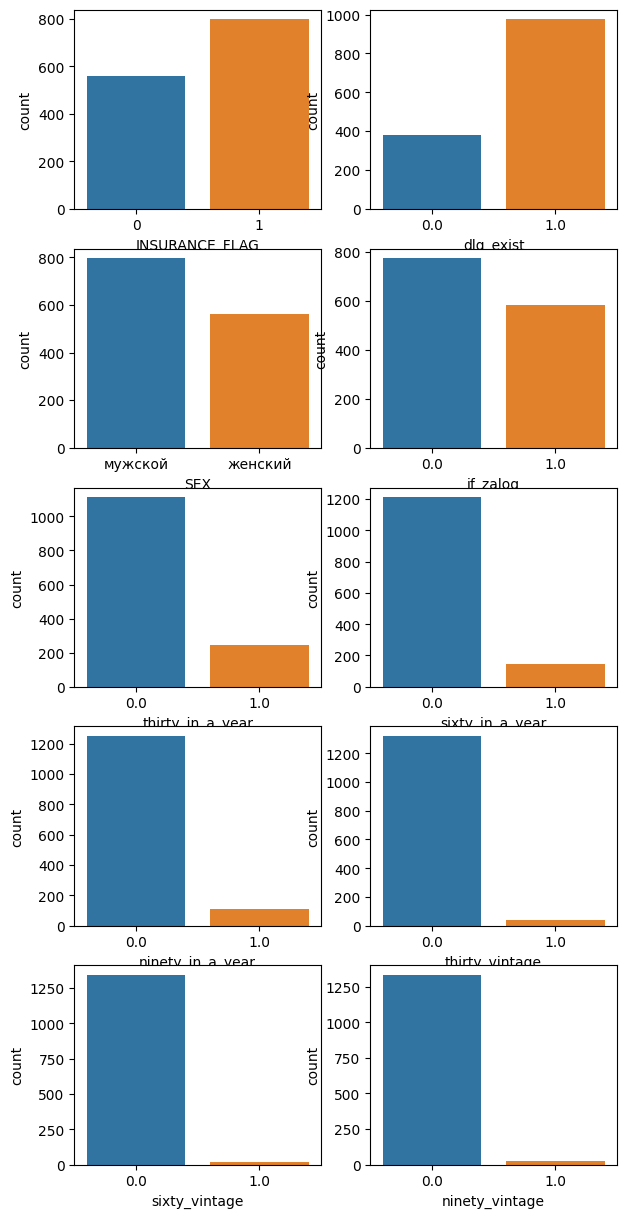

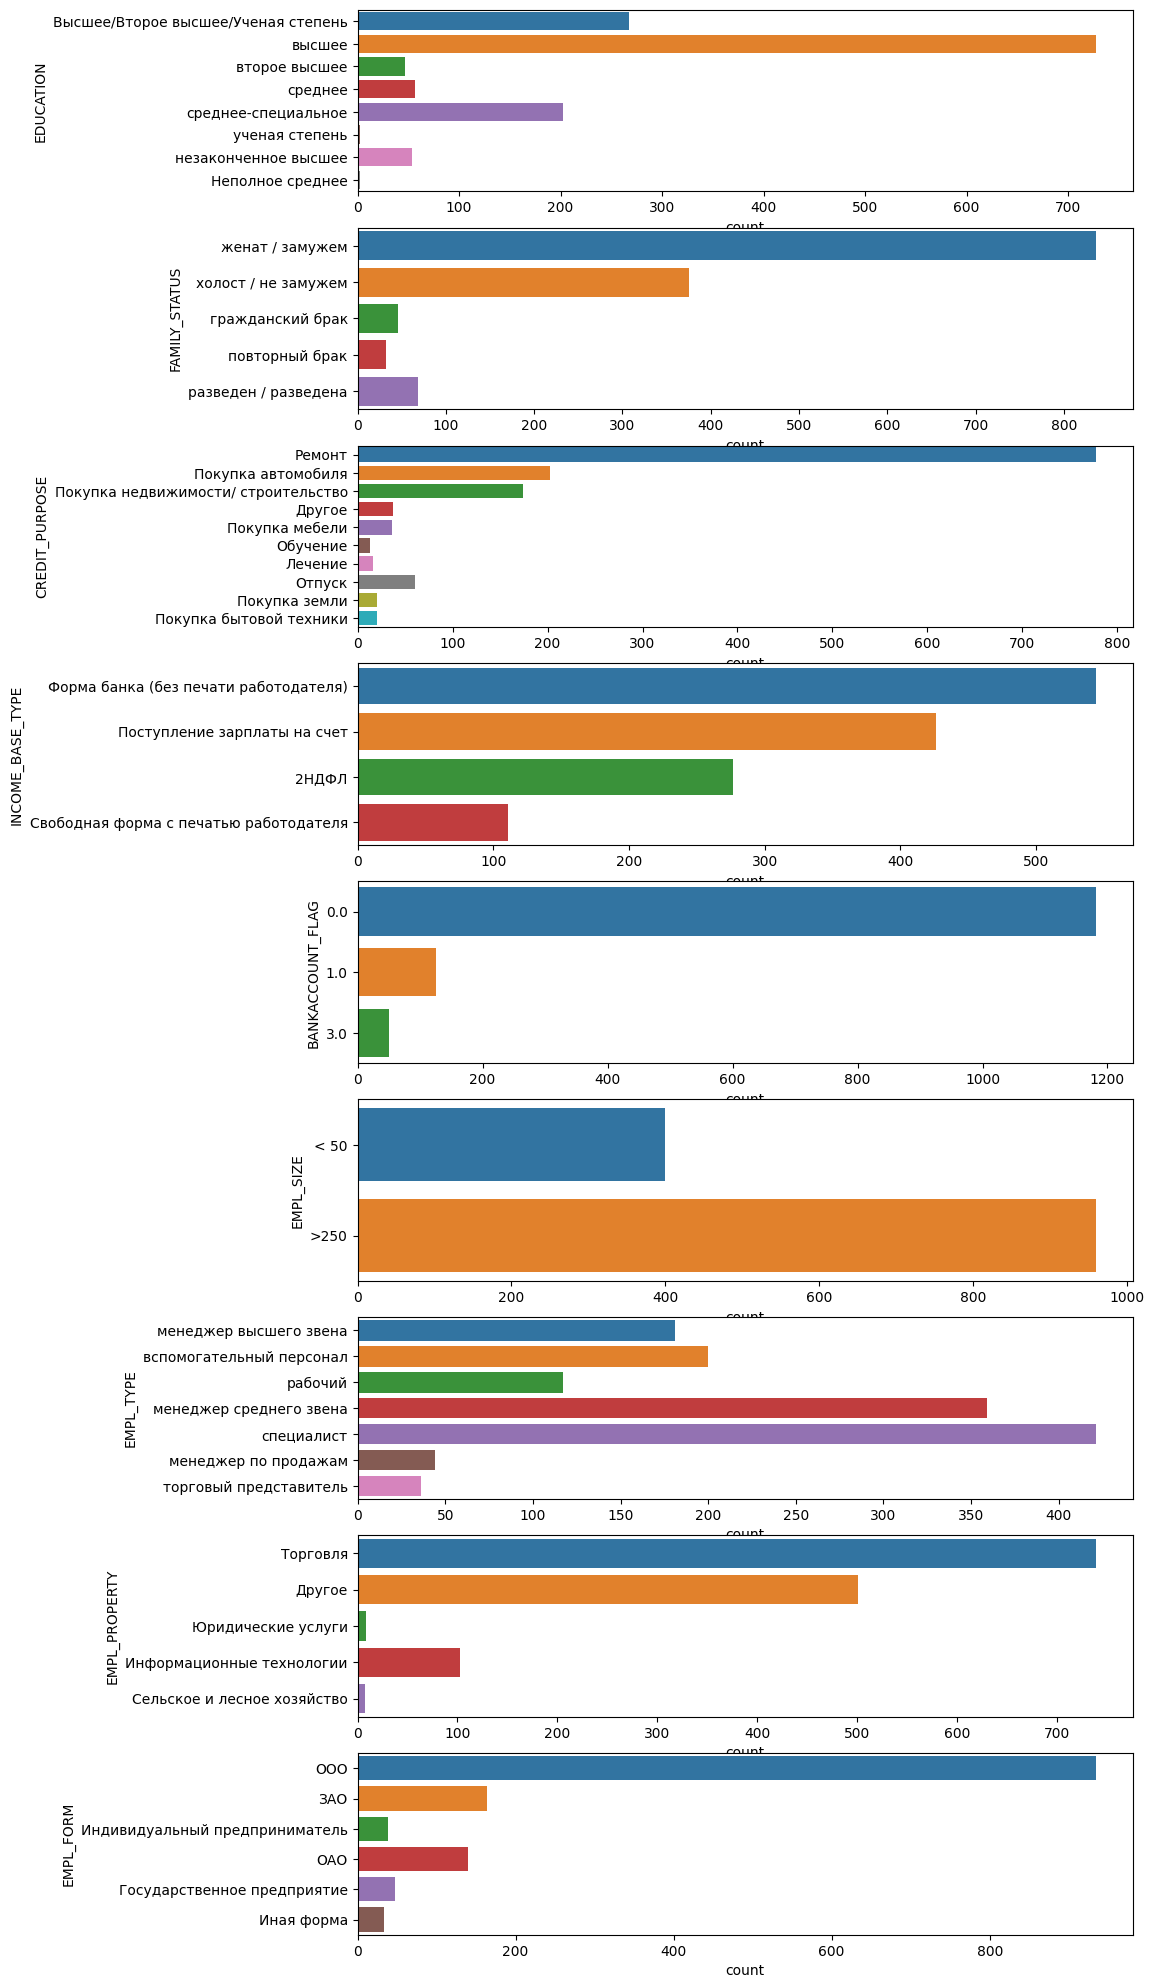

In [336]:
sns.countplot(x='age', data=cl3)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=cl3, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=cl3, ax=axs[0,1])
sns.countplot(x='SEX', data=cl3, ax=axs[1,0])
sns.countplot(x='if_zalog',data=cl3, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=cl3, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=cl3, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=cl3, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=cl3, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=cl3, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=cl3, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=cl3, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=cl3, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=cl3, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=cl3, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=cl3, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=cl3, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=cl3, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=cl3, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=cl3, ax=axs[8])

<AxesSubplot: xlabel='age'>

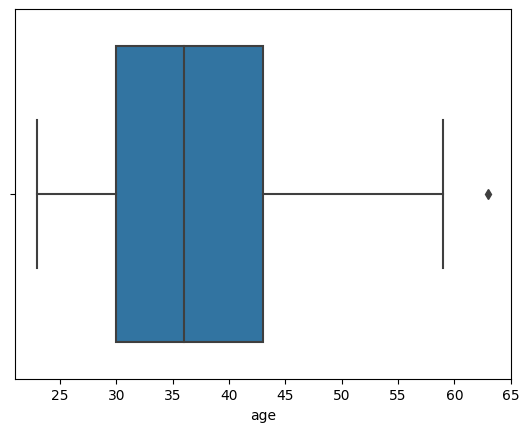

In [337]:
sns.boxplot(x=cl3["age"])

##### 4 кластер

<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

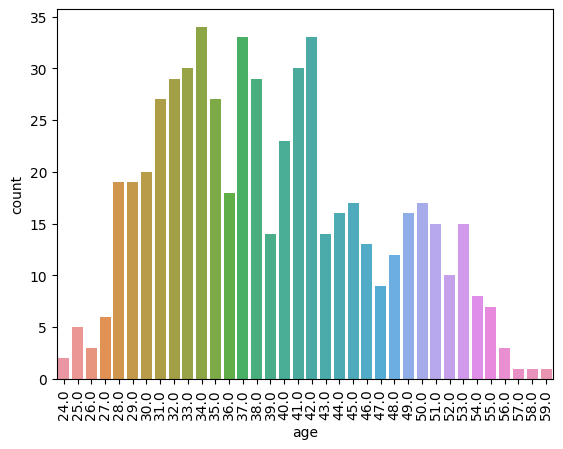

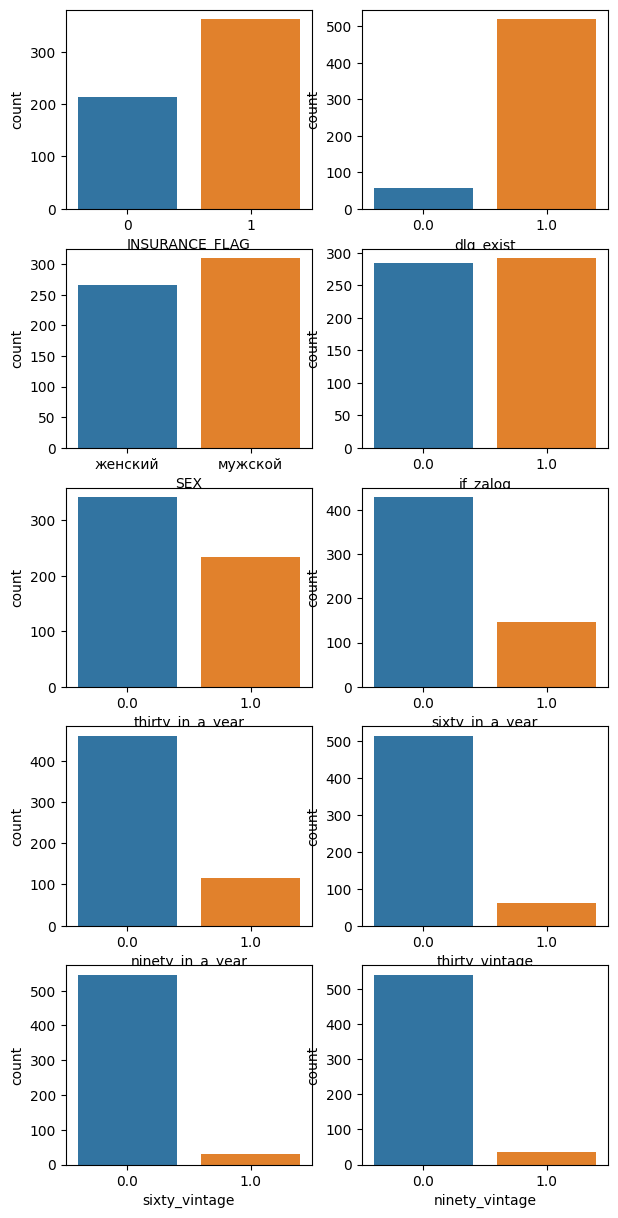

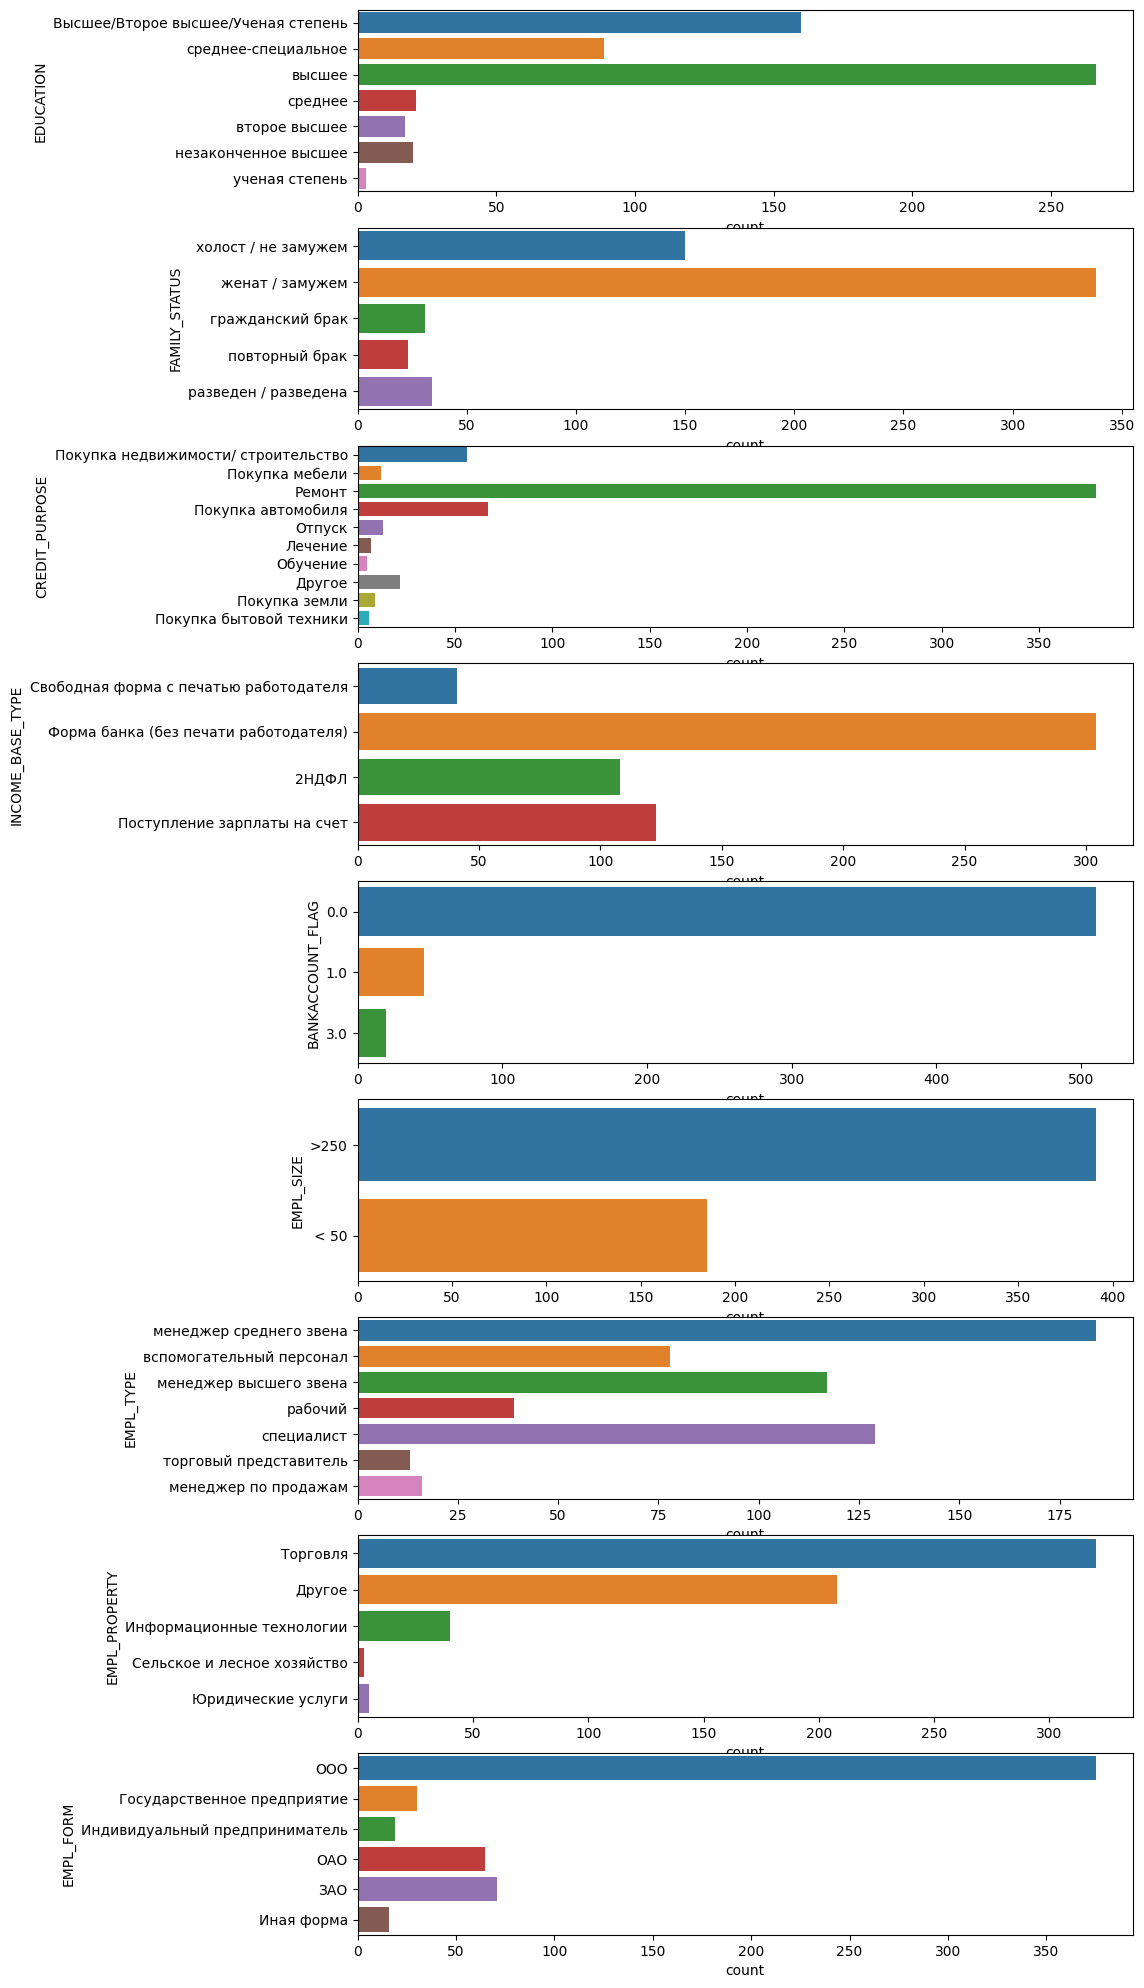

In [338]:
sns.countplot(x='age', data=cl4)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=cl4, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=cl4, ax=axs[0,1])
sns.countplot(x='SEX', data=cl4, ax=axs[1,0])
sns.countplot(x='if_zalog',data=cl4, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=cl4, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=cl4, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=cl4, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=cl4, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=cl4, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=cl4, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=cl4, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=cl4, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=cl4, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=cl4, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=cl4, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=cl4, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=cl4, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=cl4, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=cl4, ax=axs[8])

<AxesSubplot: xlabel='age'>

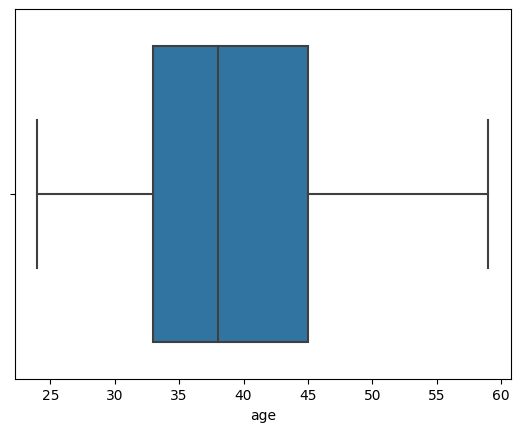

In [339]:
sns.boxplot(x=cl4["age"])

## После анализа значений в кластерах и графиков распределения величин в них для каждого кластера выявились характерные детали

## 1
## "Ответственная успешая девушка"
* Женщина, 34 года
* Почти равновероятно не замужем или замужем
* Нет детей, но могут быть иждивенцы
* Зарабатывает больше 250, но работает меньше всех
* **Редко обращается за кредитом**
* **Платит без просрочек**

## 2
## "Мама с трудностями"
* Женщина, 35 лет
* Замужем
* Скорее всего, есть ребенок
* Неопределенная должность (специалист/менеджер/персонал)
* Зарабатывает больше 250
* **В последнее время активно пытается взять кредит**
* Имеет **средний риск** по просрочкам

## 3
## "Решающий прошлые проблемы"
* Мужчина, 37 лет
* Женат
* Минимум 1 ребенок
* Неопределенная должность в неопределнной сфере
* Зарабатывает больше 250
* Закрывает **старые кредиты с просрочкой**
* **Сейчас не хочет брать новый кредит**

## 4
## "Старый клиент"
* Мужчина, 39 лет
* Женат
* Есть дети и иждивенцы 
* Менеджер в торговле, давно работает
* Зарабатывает больше 250
* **Давно и стабильно берет кредиты**
* **Закрывает** кредиты
* **Большие платежи**
* **Регулярные просрочки**

### Самый многочисленный кластер - "Ответственная успешная девушка". Потом "Решающий прошлые проблемы", затем "Старый клиент". "Мама с трудносями" - самая малочисленная.


## RFM

##### В целом понятный метод, потому что мы сами выбираем показатели, от которых отталкиваемся. Сложность опять же с количеством кластеров. Для понятности я беру 4, как в прерыдущем кейсе

##### Recency - min_MnthAfterLoan - как давно получен последний кредит
##### Frequency - all_credits - кол-во кредитов
##### Monetary - ЗП (получена путем деления отноешния долга к ЗП] на размер последнего платежа)



In [340]:
#создаем таблицу для РФМ
RFMdata = df1[['DTI', 'sum_of_paym_months', 'all_credits' ,'min_MnthAfterLoan']]
RFMdata['recency'] = RFMdata['min_MnthAfterLoan']
RFMdata['frequency'] = RFMdata['all_credits']
RFMdata['monetary'] = round(RFMdata['sum_of_paym_months'] / RFMdata['DTI'])

RFMdata = RFMdata[['recency', 'frequency', 'monetary']]
RFMdata

C:\Users\User\AppData\Local\Temp\ipykernel_11712\3988392245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMdata['recency'] = RFMdata['min_MnthAfterLoan']
C:\Users\User\AppData\Local\Temp\ipykernel_11712\3988392245.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RFMdata['frequency'] = RFMdata['all_credits']
C:\Users\User\AppData\Local\Temp\ipykernel_11712\3988392245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

recency  frequency  monetary
0        14.0        8.0    1600.0
1         5.0       11.0     447.0
2        12.0        1.0       8.0
3        25.0        8.0     335.0
4        40.0        2.0     240.0
...       ...        ...       ...
3745      5.0       14.0     454.0
3746     11.0       22.0     559.0
3747      1.0       12.0     303.0
3748      2.0        2.0      17.0
3749      1.0        1.0       7.0

[3750 rows x 3 columns]

###### Далее расчитываю RFM_SCORE для наблюдений 

In [341]:
RFMdata["RecencyScore"] = pd.qcut(RFMdata['recency'], 4, labels=[1, 2, 3, 4])
RFMdata["FrequencyScore"] = pd.qcut(RFMdata['frequency'], 4, labels=[1, 2, 3, 4])
RFMdata["MonetaryScore"] = pd.qcut(RFMdata['monetary'], 4, labels=[1, 2, 3, 4])

RFMdata["RFM_SCORE"] = (RFMdata['RecencyScore'].astype(str) +
                    RFMdata['FrequencyScore'].astype(str) +
                    RFMdata['MonetaryScore'].astype(str))
RFMdata

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


recency  frequency  monetary RecencyScore FrequencyScore MonetaryScore  \
0        14.0        8.0    1600.0            3              3             4   
1         5.0       11.0     447.0            2              4             4   
2        12.0        1.0       8.0            3              1             1   
3        25.0        8.0     335.0            4              3             4   
4        40.0        2.0     240.0            4              1             3   
...       ...        ...       ...          ...            ...           ...   
3745      5.0       14.0     454.0            2              4             4   
3746     11.0       22.0     559.0            3              4             4   
3747      1.0       12.0     303.0            1              4             3   
3748      2.0        2.0      17.0            1              1             1   
3749      1.0        1.0       7.0            1              1             1   

     RFM_SCORE  
0          334  
1          244  
2          311  
3          434  
4          413  
...        ...  
3745       244  
3746       344  
3747       143  
3748       111  
3749       111  

[3750 rows x 7 columns]

<AxesSubplot: xlabel='RFM_SCORE', ylabel='count'>

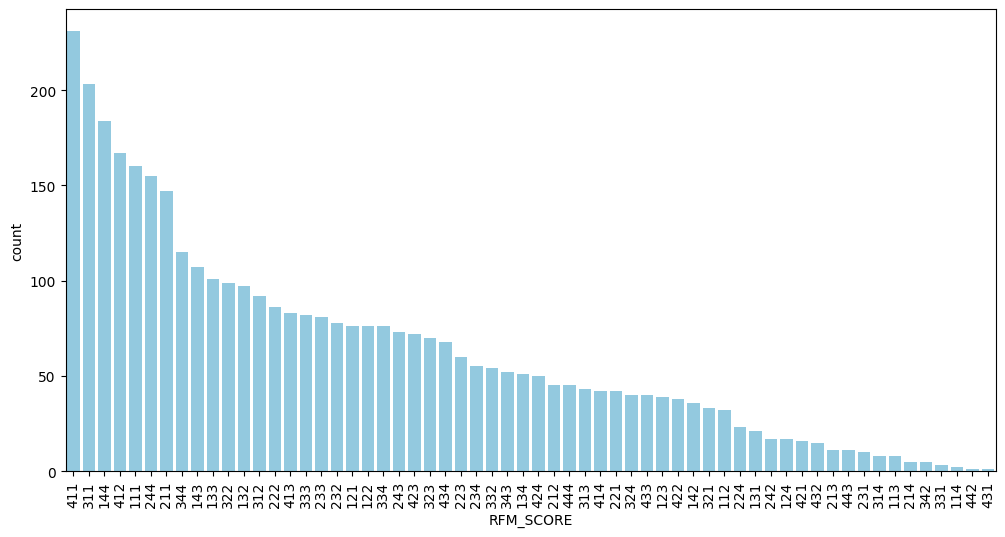

In [342]:
plt.figure(figsize = (12, 6))

plt.xticks(rotation = 90)
sns.countplot(x = 'RFM_SCORE',
              data = RFMdata,
              order = RFMdata['RFM_SCORE'].value_counts().index, color = 'skyblue')

##### Вот такой график распределения скоров по кол-ву

In [343]:
#создал словарь по RFM_SCORE и кол-ву его вхождений в датасет {RFM_SCORE: count}
values = RFMdata['RFM_SCORE'].value_counts(dropna=False).keys().tolist()
counts = RFMdata['RFM_SCORE'].value_counts(dropna=False).tolist()
value_dict = dict(zip(values, counts))
value_dict
#перенес в датасет к-во входжений по ключу - RFM_SCORE
RFMdata['count'] = RFMdata['RFM_SCORE'].map(value_dict)

new_df = RFMdata.groupby('RFM_SCORE').agg({'count': 'first'}).reset_index().sort_values(by = 'count', ascending = False)

In [344]:
#поделил по квантилям и присвоил названия
new_df["segment"] = pd.qcut(new_df["count"], 4, labels = ['a','b','c','d'])
new_df.reset_index().drop(columns = 'index')
#соединил предыдущую таблицу со скором и сегментом с таблицей РФМ. Мержил по значению РФМ
kek = pd.merge(RFMdata, new_df, on='RFM_SCORE', how = 'left')
kek = kek.drop(columns = ['count_x', 'count_y'])
kek

recency  frequency  monetary RecencyScore FrequencyScore MonetaryScore  \
0        14.0        8.0    1600.0            3              3             4   
1         5.0       11.0     447.0            2              4             4   
2        12.0        1.0       8.0            3              1             1   
3        25.0        8.0     335.0            4              3             4   
4        40.0        2.0     240.0            4              1             3   
...       ...        ...       ...          ...            ...           ...   
3745      5.0       14.0     454.0            2              4             4   
3746     11.0       22.0     559.0            3              4             4   
3747      1.0       12.0     303.0            1              4             3   
3748      2.0        2.0      17.0            1              1             1   
3749      1.0        1.0       7.0            1              1             1   

     RFM_SCORE segment  
0          334       c  
1          244       d  
2          311       d  
3          434       c  
4          413       d  
...        ...     ...  
3745       244       d  
3746       344       d  
3747       143       d  
3748       111       d  
3749       111       d  

[3750 rows x 8 columns]

###### Переношу названия сегментов в изначальную таблицу. Просто вставлю новым столбцом, потому что индексы совпадают и они не менялись 

In [345]:
dataset['segment'] = kek['segment']
dataset['segment'].describe()

count     3750
unique       4
top          d
freq      2027
Name: segment, dtype: object

In [363]:
#выделяю отдельные датасеты по кластерам
dataset_a = dataset.loc[dataset['segment'] == 'a']
dataset_b = dataset.loc[dataset['segment'] == 'b']
dataset_c = dataset.loc[dataset['segment'] == 'c']
dataset_c = dataset.loc[dataset['segment'] == 'c']

#самые частиы RFM_SCORE в сегментах
print('a: ',kek.loc[kek['segment'] == 'a']['RFM_SCORE'].mode())
print('b: ',kek.loc[kek['segment'] == 'b']['RFM_SCORE'].mode())
print('c: ',kek.loc[kek['segment'] == 'c']['RFM_SCORE'].mode())
print('d: ',kek.loc[kek['segment'] == 'd']['RFM_SCORE'].mode())

a:  0    124
1    242
Name: RFM_SCORE, dtype: object
b:  0    424
Name: RFM_SCORE, dtype: object
c:  0    333
Name: RFM_SCORE, dtype: object
d:  0    411
Name: RFM_SCORE, dtype: object


### Смотрю по каждому сегменту разбивку

In [352]:
seg = pd.DataFrame()
seg['a'] = dataset_a.mean()
seg['b'] = dataset_b.mean()
seg['c'] = dataset_c.mean()
seg['d'] = dataset_d.mean()
print('a: ',dataset_a['DTI'].count())
print('b: ',dataset_b['DTI'].count())
print('c: ',dataset_c['DTI'].count())
print('d: ',dataset_d['DTI'].count())
print(seg)

a:  130
b:  569
c:  1024
d:  2027
                               a          b          c          d
INSURANCE_FLAG          0.592308   0.592267   0.618164   0.624075
DTI                     0.385538   0.342987   0.402568   0.397055
FULL_AGE_CHILD_NUMBER   0.600000   0.594025   0.558594   0.526887
DEPENDANT_NUMBER        0.000000   0.005272   0.001953   0.002467
BANKACCOUNT_FLAG        0.353846   0.256591   0.321289   0.310311
Period_at_work         73.561538  56.502636  57.923828  53.669956
age                    38.523077  36.586995  36.369141  35.446966
max90days               1.453846   1.530756   1.660156   1.754317
max60days               1.146154   1.072056   1.146484   1.247657
max30days               0.900000   0.803163   0.831055   0.899359
max21days               0.669231   0.629174   0.607422   0.656142
max14days               0.515385   0.488576   0.468750   0.552047
avg_num_delay           0.081072   0.064456   0.064687   0.056675
if_zalog                0.300000   0.33216

C:\Users\User\AppData\Local\Temp\ipykernel_11712\3239994059.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  seg['a'] = dataset_a.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\3239994059.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  seg['b'] = dataset_b.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\3239994059.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  seg['c'] = dataset_c.mean()
C:\Users\User\AppData\Local\Temp\ipykernel_11712\3239994059.py:5: Futu

##### Сегмент А

## A "Неорганизованный семьянин"
* Мужчина, 38 лет
* Женат
* Скорее всего есть ребенок, без иждивенцев
* Специалист или менеджер в торговле, давно работает
* Заработок больше 250
* **Давно берет кредиты**
* **Большая доля незакрытых**
* **Частые просрочки**

Самый частый RFM в этом кластере частично подтверждает портрет - 124. Берет с давних пор, нотносительно часто и много


<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

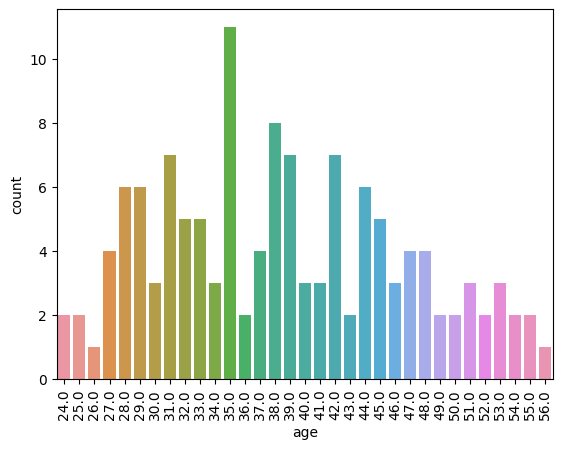

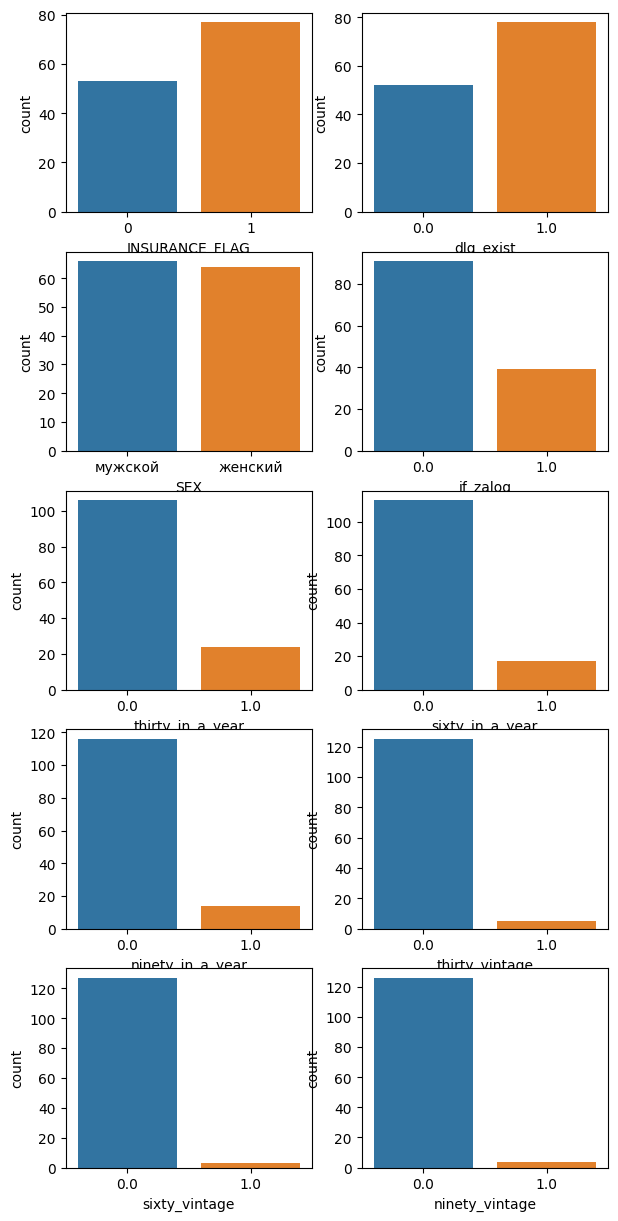

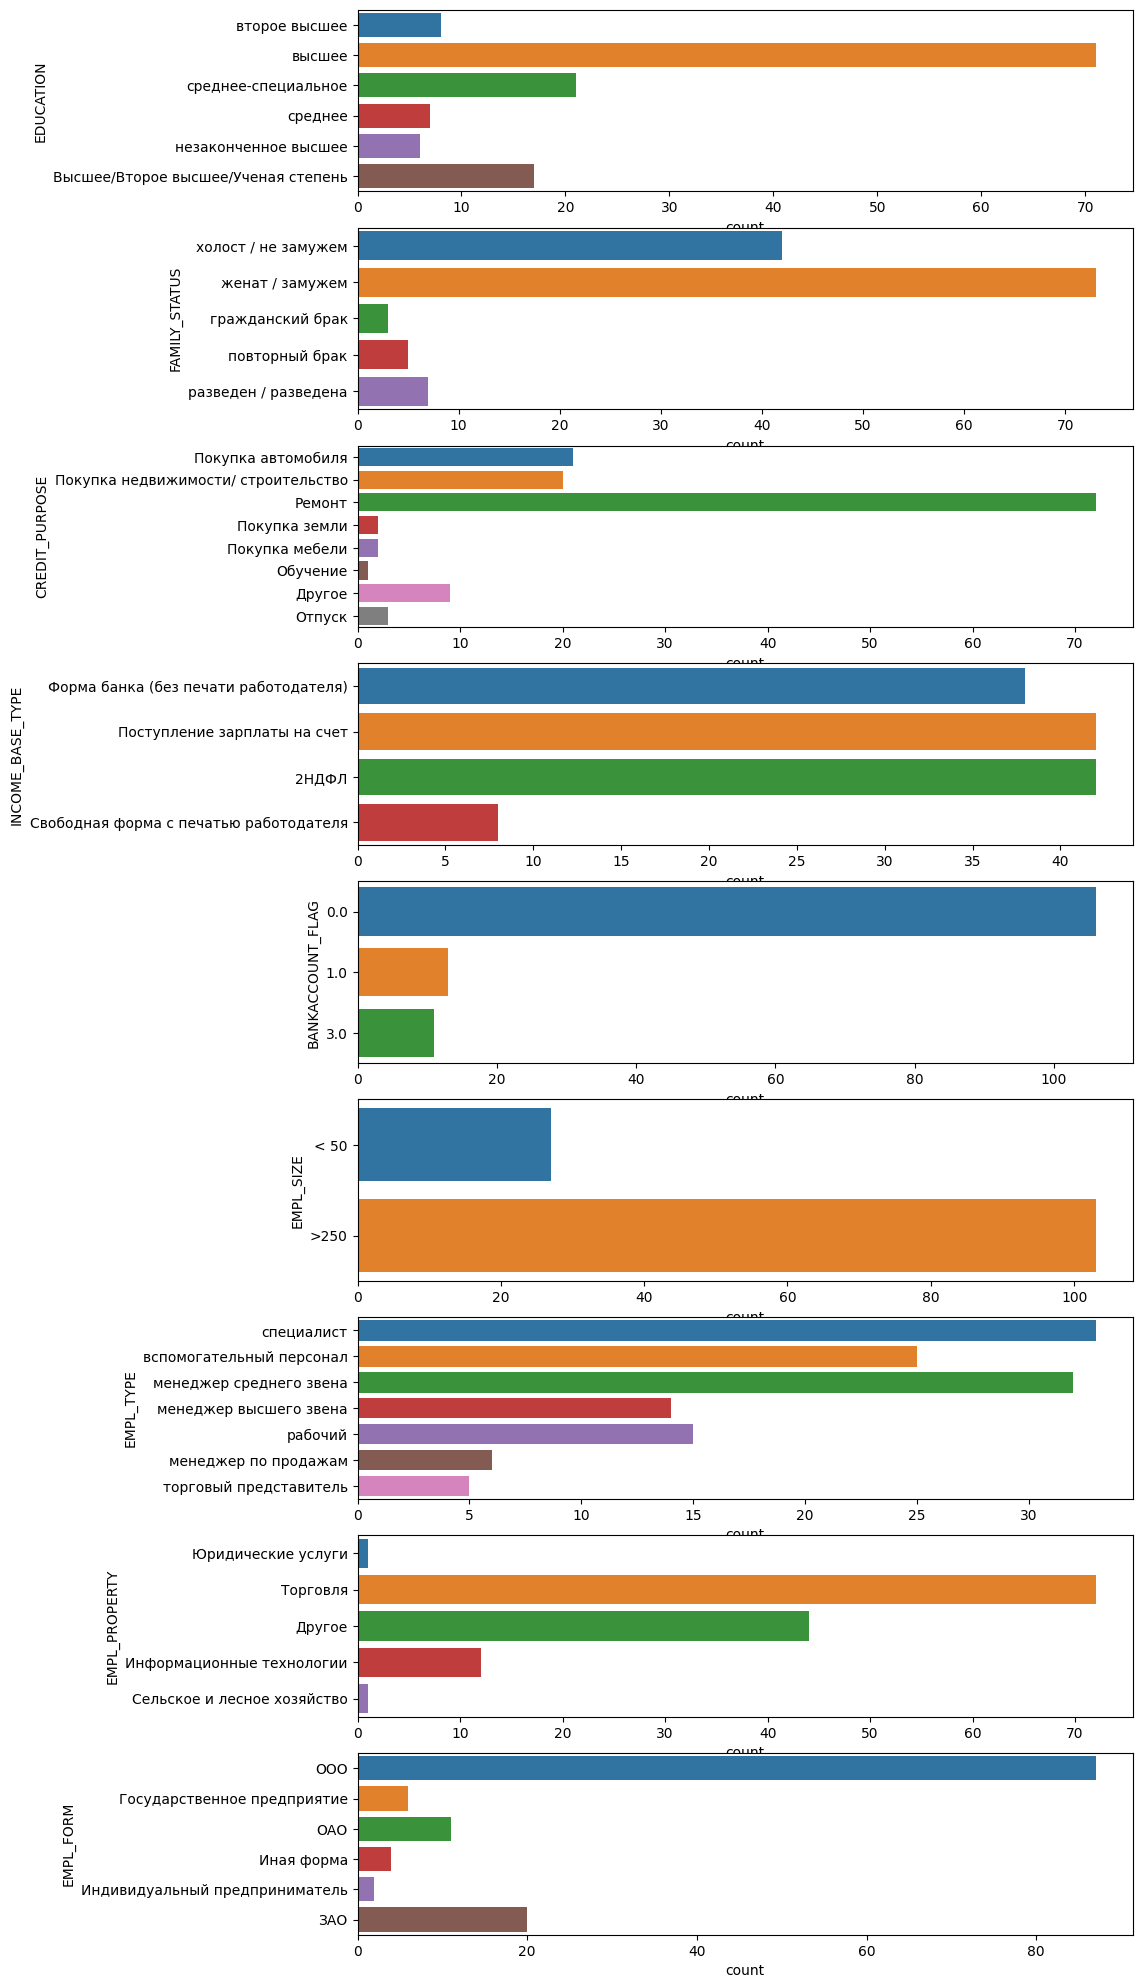

In [347]:
sns.countplot(x='age', data=dataset_a)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=dataset_a, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=dataset_a, ax=axs[0,1])
sns.countplot(x='SEX', data=dataset_a, ax=axs[1,0])
sns.countplot(x='if_zalog',data=dataset_a, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=dataset_a, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=dataset_a, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=dataset_a, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=dataset_a, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=dataset_a, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=dataset_a, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=dataset_a, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=dataset_a, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=dataset_a, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=dataset_a, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=dataset_a, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=dataset_a, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=dataset_a, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=dataset_a, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=dataset_a, ax=axs[8])

##### Сегмент B

## В "Успешная женщина"
* Женщина, 36 лет
* Замужем
* Скорее всего есть ребенок и иждивенец
* Специалист или менеджер в торговле
* Заработок больше 250
* **Берет мало кредитов**
* **Последний кредит был давно**
* **Бывают просрочки**

Самый частый RFM в этом - 424. Здесь он меньше совпадает с портретом


<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

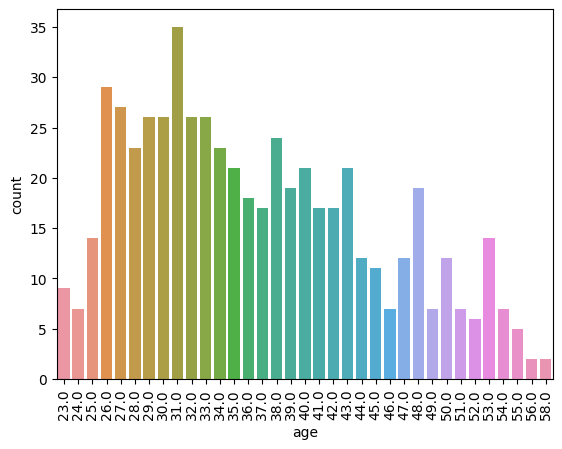

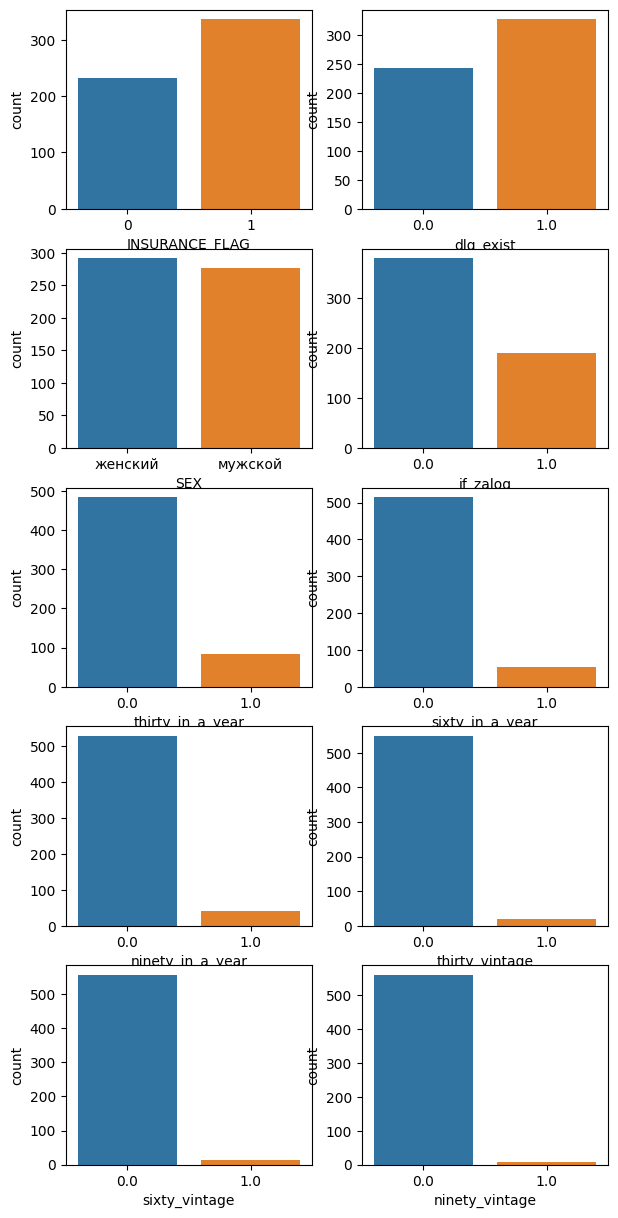

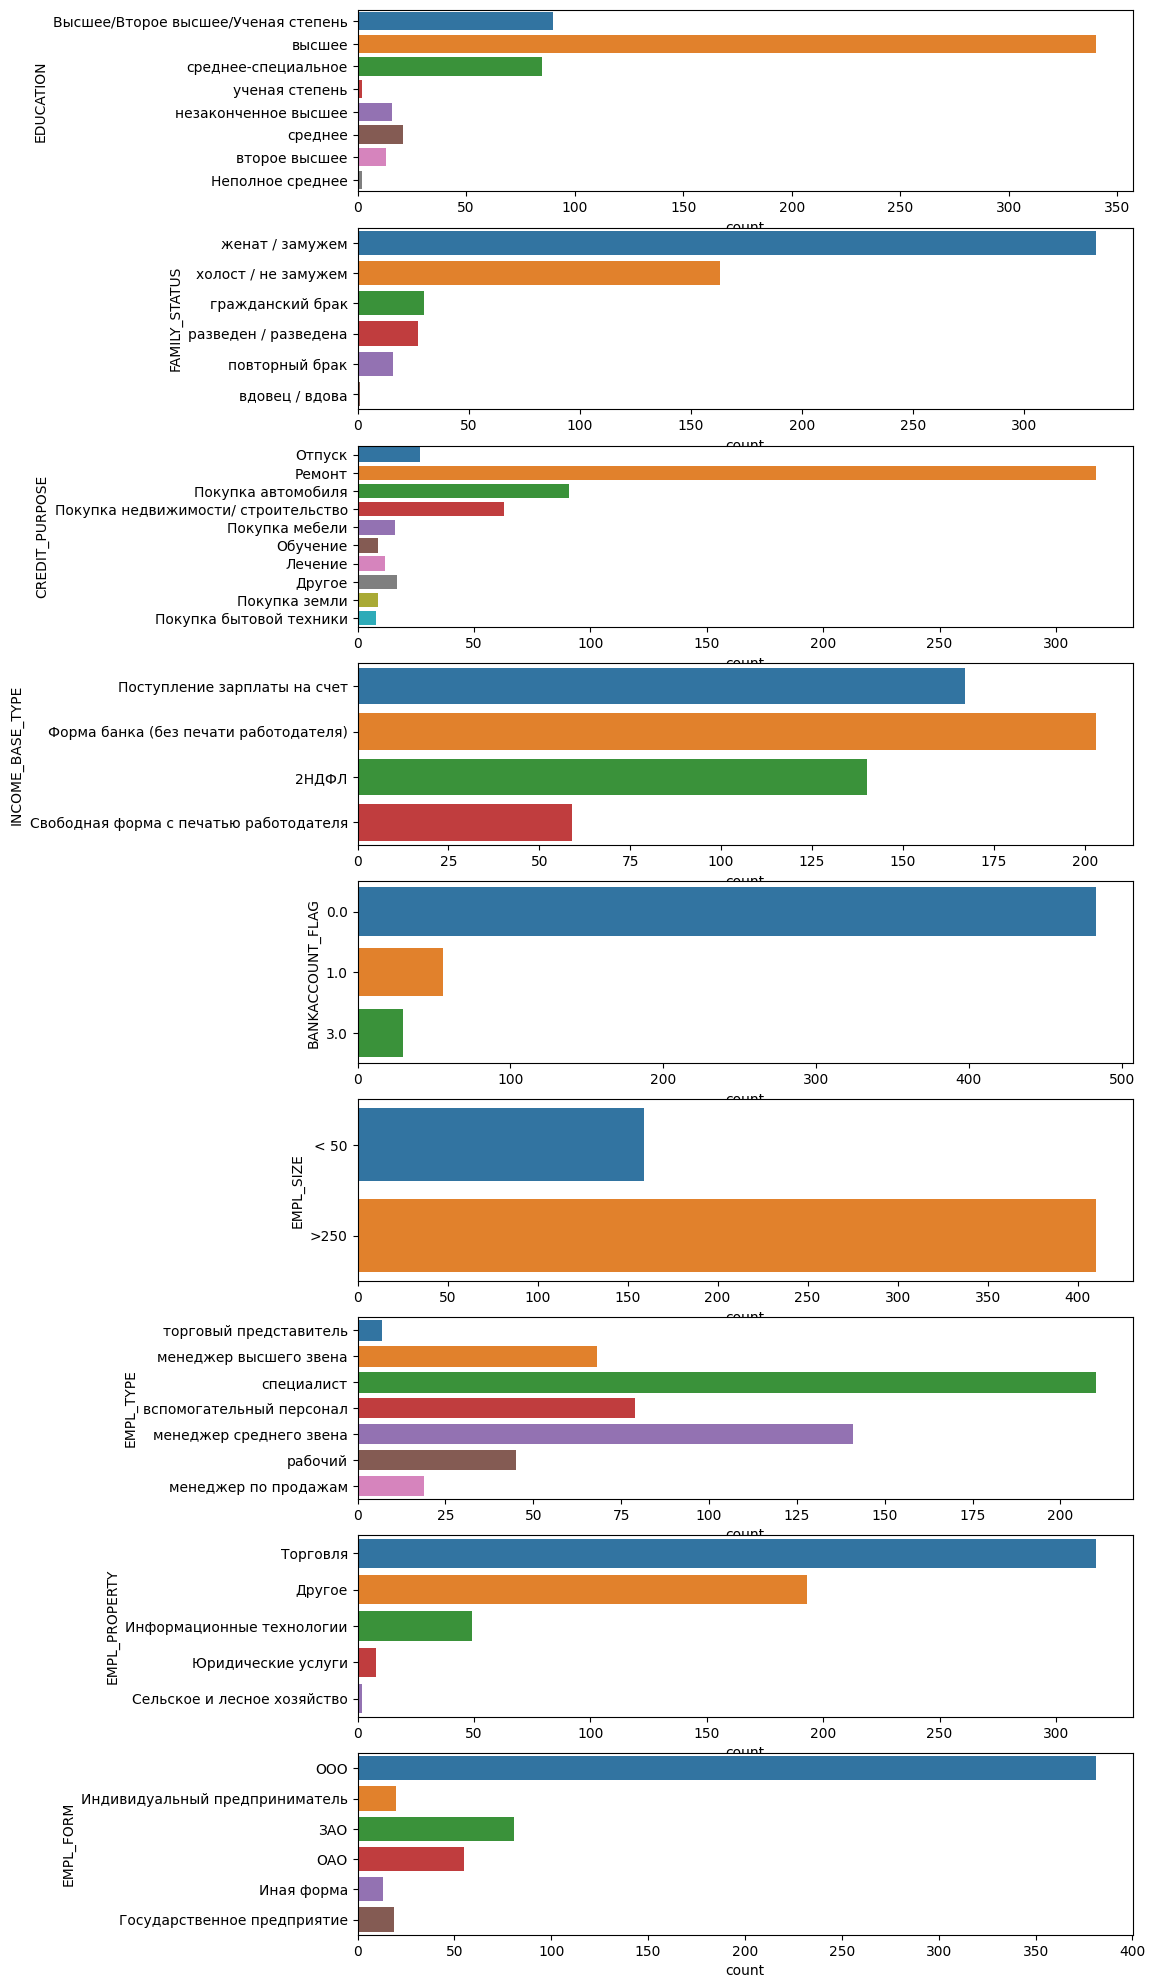

In [348]:
sns.countplot(x='age', data=dataset_b)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=dataset_b, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=dataset_b, ax=axs[0,1])
sns.countplot(x='SEX', data=dataset_b, ax=axs[1,0])
sns.countplot(x='if_zalog',data=dataset_b, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=dataset_b, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=dataset_b, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=dataset_b, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=dataset_b, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=dataset_b, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=dataset_b, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=dataset_b, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=dataset_b, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=dataset_b, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=dataset_b, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=dataset_b, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=dataset_b, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=dataset_b, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=dataset_b, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=dataset_b, ax=axs[8])

##### Сегмент C

## С "Безотказный"
* Мужчина, 36 лет
* Женат
* Возможно, есть ребенок
* Специалист или менеджер в торговле
* Заработок больше 250
* **Берет много кредитов**
* **Недавно был последний кредит**
* **Самая большая доля закрытых кредитов**
* **Бывают просрочки**
* **Большие платежи** и **самое большое отношение долгов к ЗП**
 
Самый частый RFM в этом кластере в цело описывает кластер - 333. Берет с много, часто и не так давно


<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

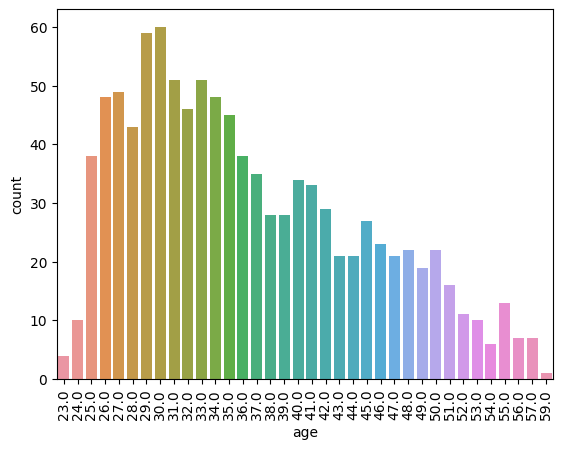

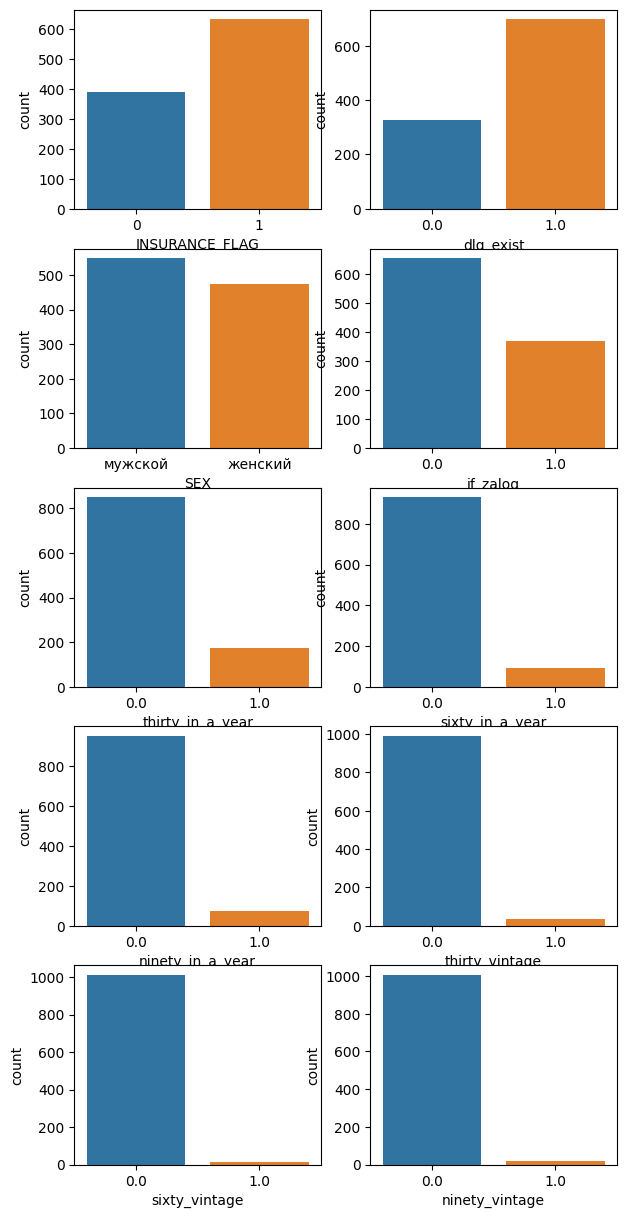

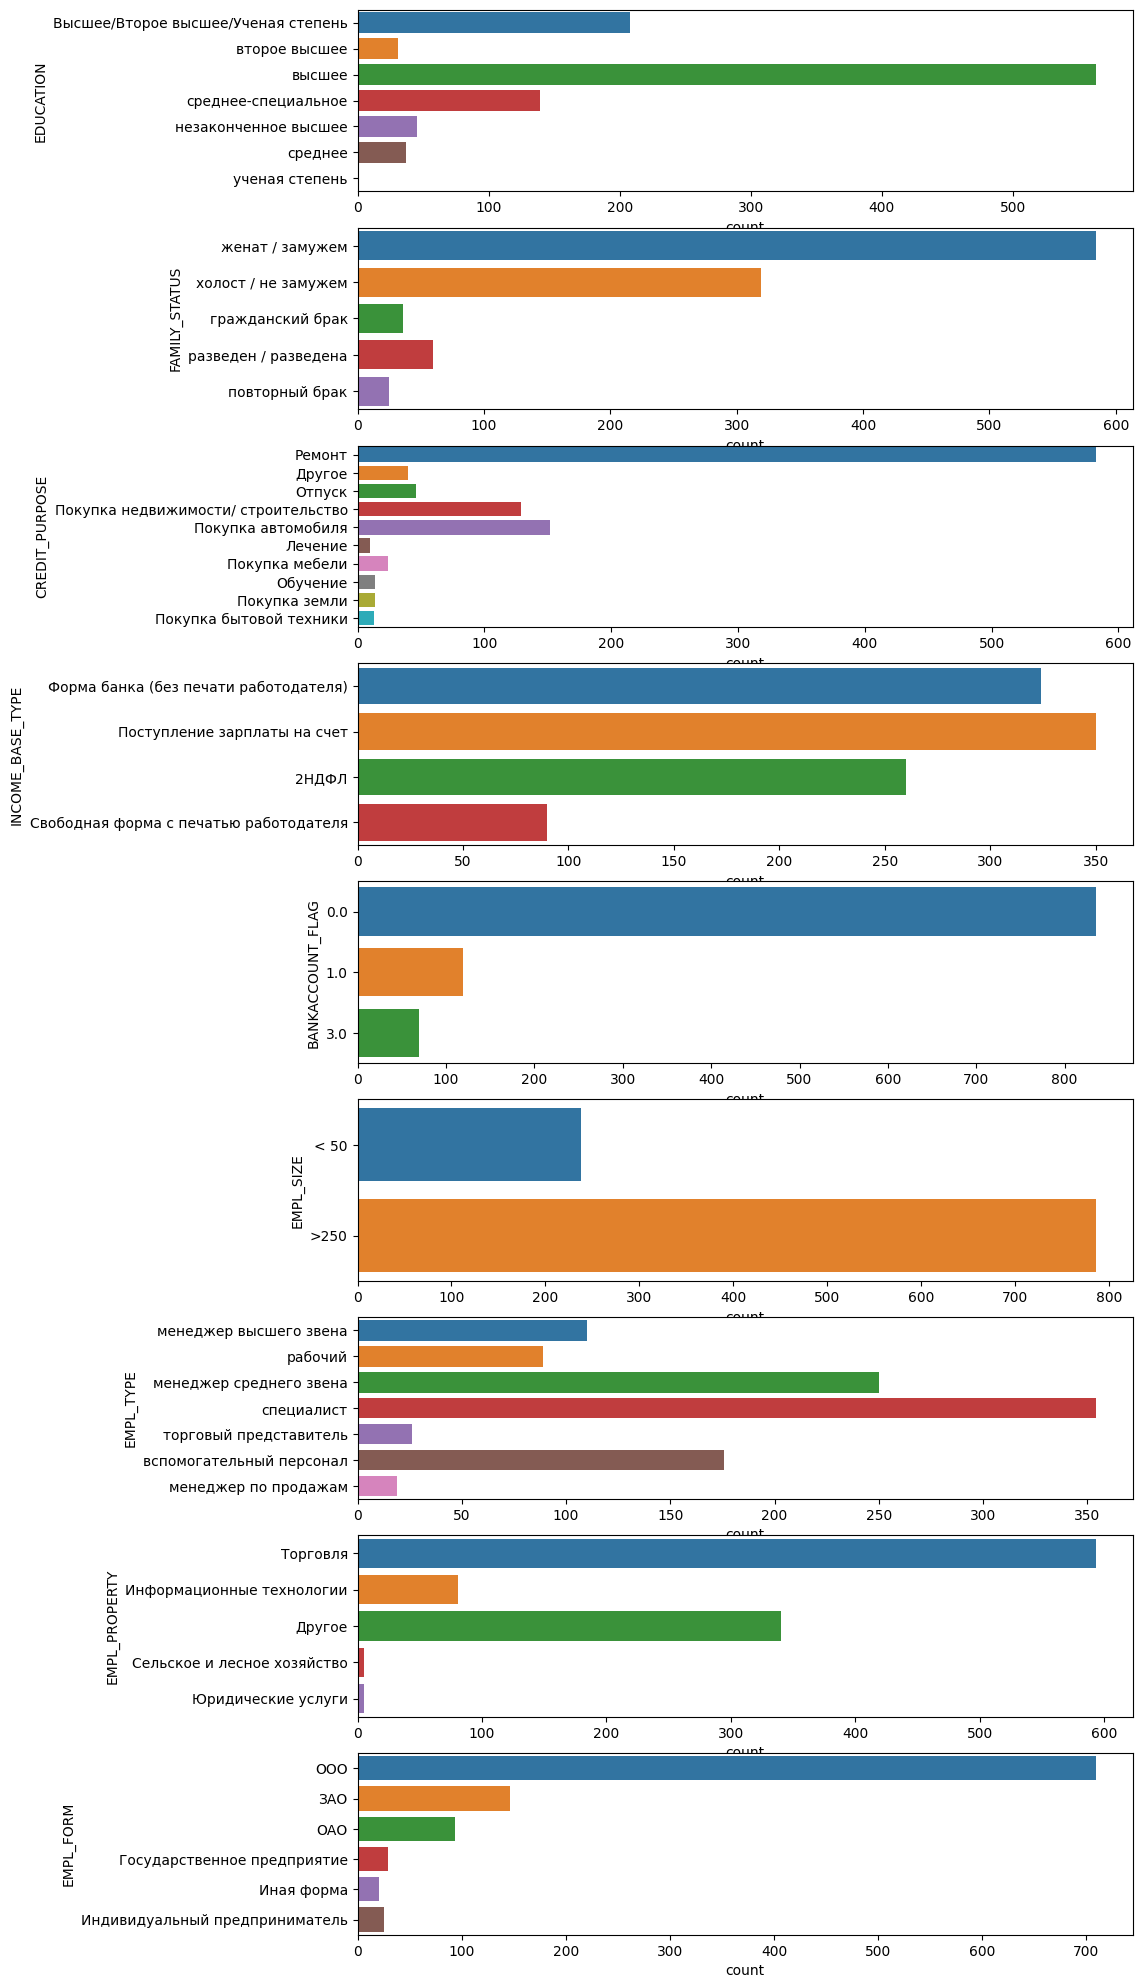

In [349]:
sns.countplot(x='age', data=dataset_c)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=dataset_c, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=dataset_c, ax=axs[0,1])
sns.countplot(x='SEX', data=dataset_c, ax=axs[1,0])
sns.countplot(x='if_zalog',data=dataset_c, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=dataset_c, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=dataset_c, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=dataset_c, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=dataset_c, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=dataset_c, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=dataset_c, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=dataset_c, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=dataset_c, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=dataset_c, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=dataset_c, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=dataset_c, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=dataset_c, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=dataset_c, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=dataset_c, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=dataset_c, ax=axs[8])

##### Сегмент D

## D "Успешный мужчина"
* Мужчина, 35 лет
* Женат
* Вероятнее всего, нет ребенка
* Неопределенная должность в торговле, работает недавно
* Заработок больше 250
* **Стал брать недавно**
* **Берет нечасто**
* **Большая доля закрытых кредитов**
* **Редкие просрочки по платежам**

Самый частый RFM в этом кластере подтверждает портрет - 411. Берет с очень недавних пор,нечасто и немного


<AxesSubplot: xlabel='count', ylabel='EMPL_FORM'>

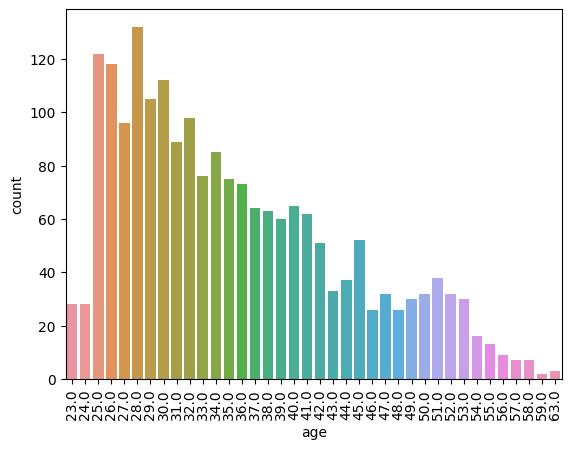

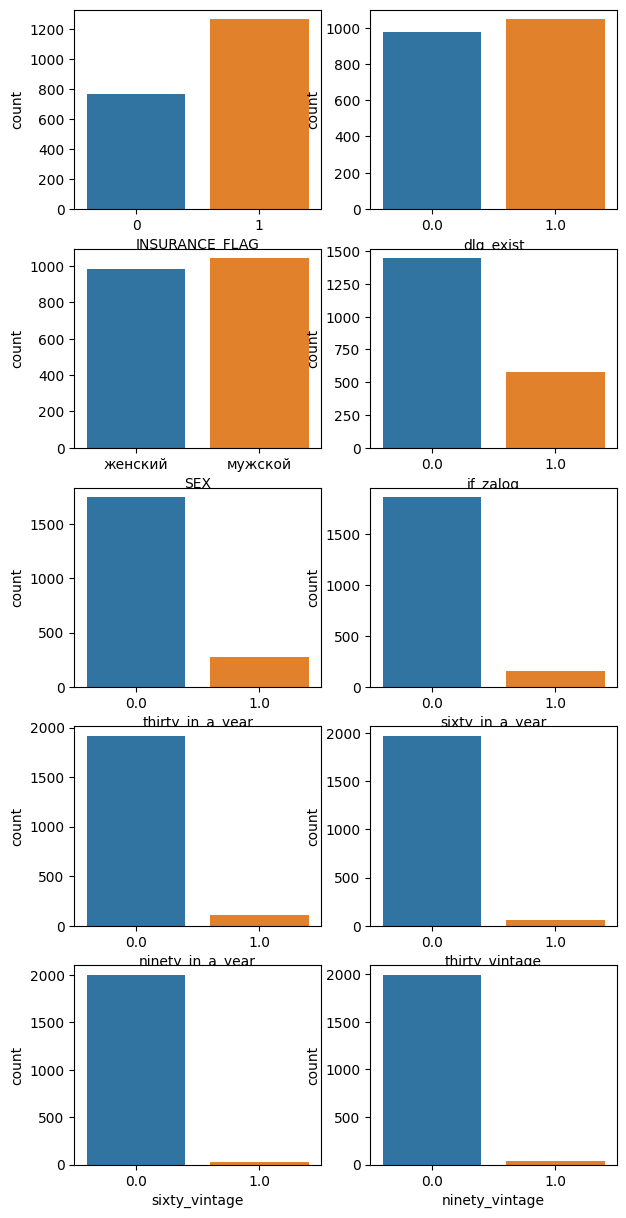

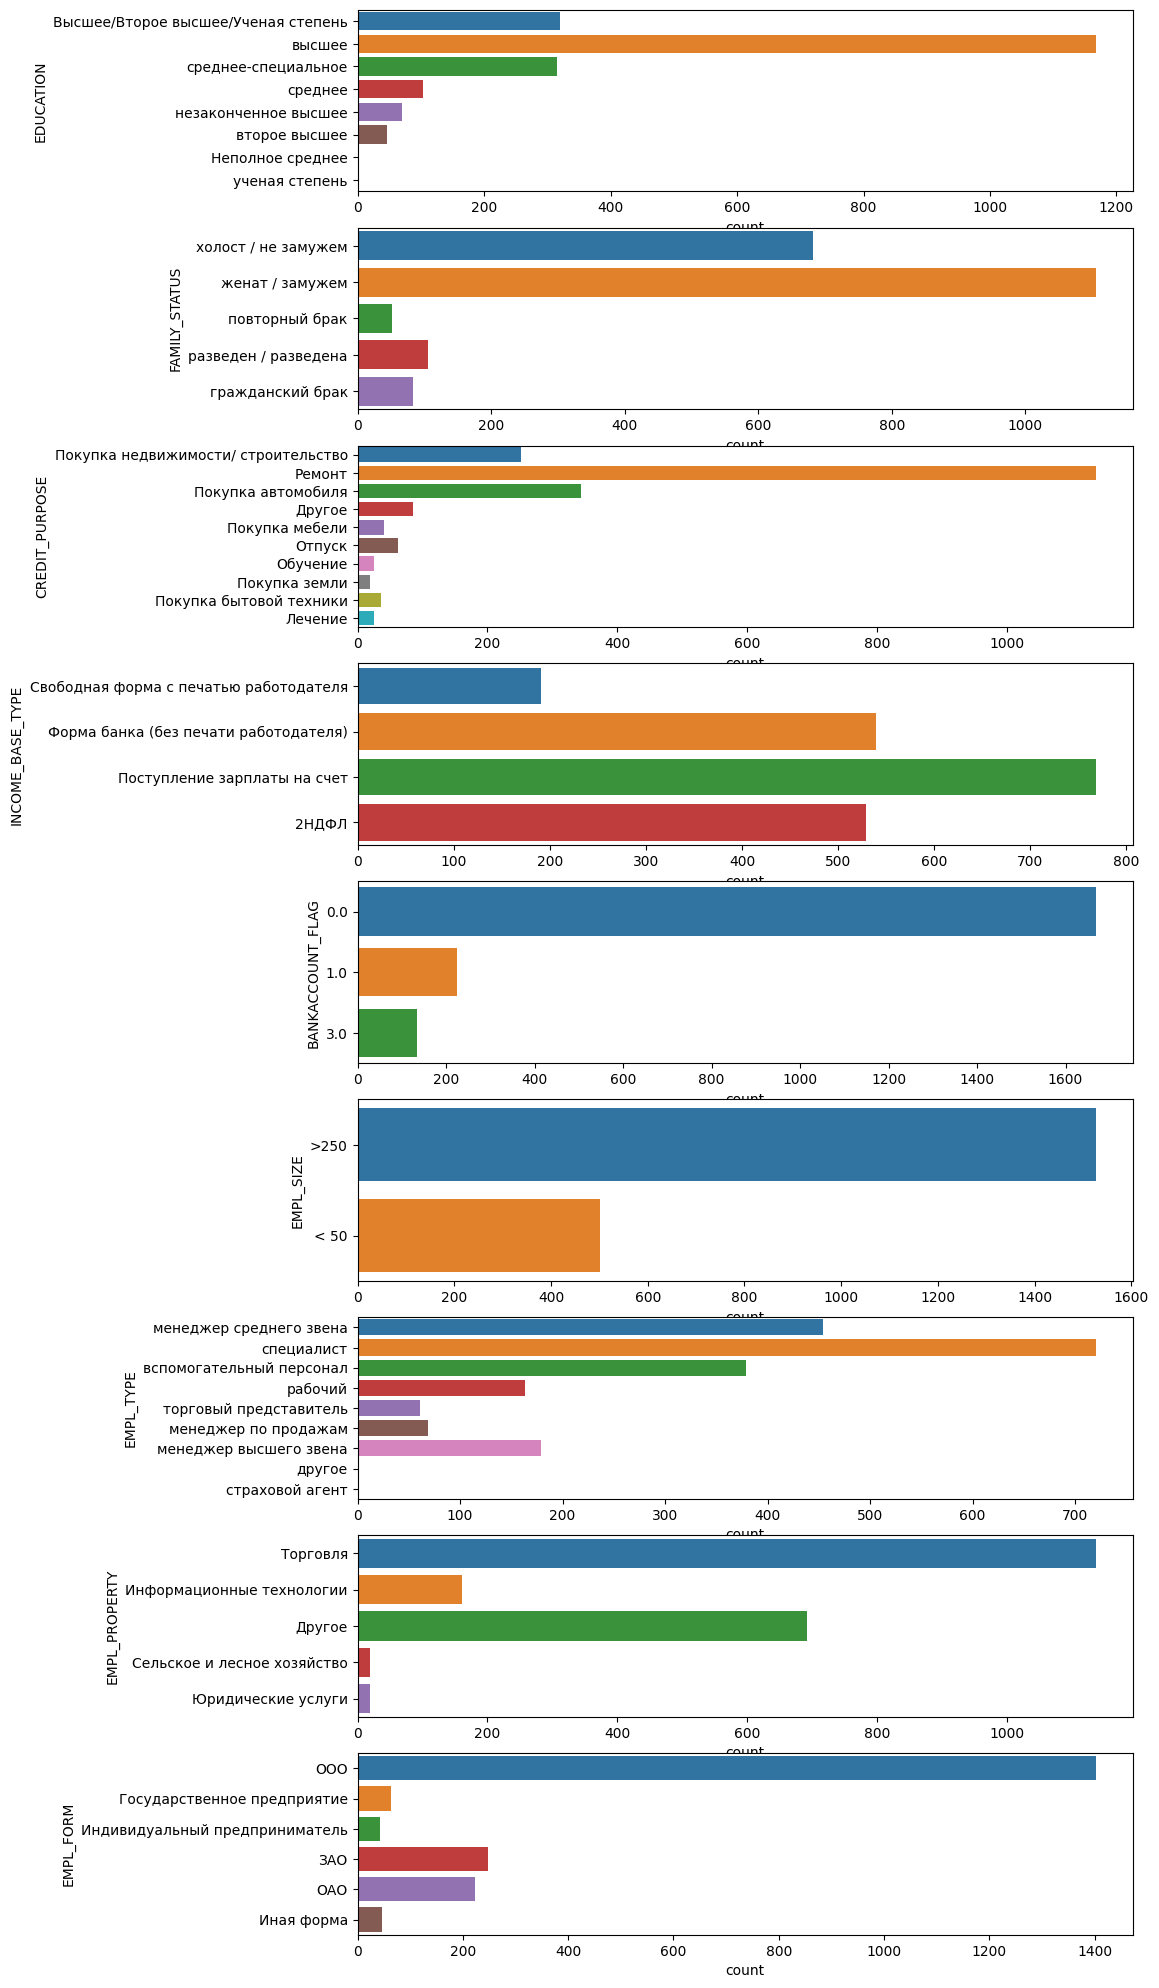

In [350]:
sns.countplot(x='age', data=dataset_d)
plt.xticks(rotation = 90)
fig, axs = plt.subplots(5, 2, figsize=(7, 15))
sns.countplot(x='INSURANCE_FLAG', data=dataset_d, ax=axs[0,0])
sns.countplot(x='dlq_exist',data=dataset_d, ax=axs[0,1])
sns.countplot(x='SEX', data=dataset_d, ax=axs[1,0])
sns.countplot(x='if_zalog',data=dataset_d, ax=axs[1,1])
sns.countplot(x='thirty_in_a_year', data=dataset_d, ax=axs[2,0])
sns.countplot(x='sixty_in_a_year',data=dataset_d, ax=axs[2,1])
sns.countplot(x='ninety_in_a_year', data=dataset_d, ax=axs[3,0])
sns.countplot(x='thirty_vintage',data=dataset_d, ax=axs[3,1])
sns.countplot(x='sixty_vintage', data=dataset_d, ax=axs[4,0])
sns.countplot(x='ninety_vintage',data=dataset_d, ax=axs[4,1])

fig, axs = plt.subplots(9, 1, figsize=(10, 25))
sns.countplot(y='EDUCATION', data=dataset_d, ax=axs[0])
sns.countplot(y='FAMILY_STATUS', data=dataset_d, ax=axs[1])
sns.countplot(y='CREDIT_PURPOSE', data=dataset_d, ax=axs[2])
sns.countplot(y='INCOME_BASE_TYPE', data=dataset_d, ax=axs[3])
sns.countplot(y='BANKACCOUNT_FLAG', data=dataset_d, ax=axs[4])
sns.countplot(y='EMPL_SIZE', data=dataset_d, ax=axs[5])
sns.countplot(y='EMPL_TYPE', data=dataset_d, ax=axs[6])
sns.countplot(y='EMPL_PROPERTY', data=dataset_d, ax=axs[7])
sns.countplot(y='EMPL_FORM', data=dataset_d, ax=axs[8])